<a id = "2"></a><br>
# Load Python Pakages


In [1]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.preprocessing import QuantileTransformer, quantile_transform

#statistics
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p


#feature engineering
from sklearn.feature_selection import mutual_info_classif


#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config


#algorithms
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression # Don't use it. (This is a multiclass classification problem)
from sklearn.svm import SVC


#model evaluation
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, log_loss, f1_score
from sklearn.metrics import make_scorer, accuracy_score

# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice


random_state = 42


<a id = "3"></a><br>
#  First look to data

In [2]:
# Read the data
original_train_df = pd.read_csv('data.csv',  index_col='ID')

# reserved 
pipe_data = original_train_df.copy()

# use for analysis
train_df = original_train_df.copy()
train_df.head()

Age  Sex  Education     BMI Physical_activity_level  HgbA1C  \
ID                                                                   
10001   53    1          9  26.533                                   
10002   60    1         12                             585           
10004   69    1         12  21.427                          6.4952   
10005   70    2          5  26.508                    1680           
10006   51    2          6  26.892                           6.242   

      Total_cholesterol blood_triglycerids blood_HDL blood_LDL  ...  \
ID                                                              ...   
10001                                                           ...   
10002                                   92        38        50  ...   
10004               106                                         ...   
10005                                  187        39       147  ...   
10006               223                                         ...   

      DelayedRecall delayed_repet delayed_intrus Processing_speed Reasoning  \
ID                                                                            
10001                                                                         
10002             0             0              1               45         4   
10004                                                                         
10005             3             0              1               30         0   
10006                                                                         

      Category_fluency fluency_repet fluency_intrus Working_memory   SGST  
ID                                                                         
10001                                                                      
10002               14             0              0              4  1.013  
10004                                                                      
10005               10             0              0              2  1.196  
10006                                                                      

[5 rows x 46 columns]

In [3]:
train_df.shape

(7108, 46)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7108 entries, 10001 to 19193
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age                             7108 non-null   int64 
 1   Sex                             7108 non-null   int64 
 2   Education                       7108 non-null   int64 
 3   BMI                             7108 non-null   object
 4   Physical_activity_level         7108 non-null   object
 5   HgbA1C                          7108 non-null   object
 6   Total_cholesterol               7108 non-null   object
 7   blood_triglycerids              7108 non-null   object
 8   blood_HDL                       7108 non-null   object
 9   blood_LDL                       7108 non-null   object
 10  total_HDL_ratio                 7108 non-null   object
 11  blood_creatinine                7108 non-null   object
 12  blood_DHEA_S                    7108 non-nu

There are some empty entries, but they are not recognized as nan. Also, numerical columns are identified as objects. Let's correct these issues. 

In [5]:
train_df = train_df.replace(r'^\s*$', np.nan, regex=True)
features_need_type_change = train_df.select_dtypes(include='object').columns
train_df[features_need_type_change] = train_df[features_need_type_change].astype("float")
train_df = train_df.drop(train_df[train_df['Sex'] == 8].index)
train_df['Sex'] = train_df['Sex'].astype('category')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7027 entries, 10001 to 19193
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Age                             7027 non-null   int64   
 1   Sex                             7027 non-null   category
 2   Education                       7027 non-null   int64   
 3   BMI                             6325 non-null   float64 
 4   Physical_activity_level         1052 non-null   float64 
 5   HgbA1C                          1052 non-null   float64 
 6   Total_cholesterol               1052 non-null   float64 
 7   blood_triglycerids              1052 non-null   float64 
 8   blood_HDL                       1052 non-null   float64 
 9   blood_LDL                       1052 non-null   float64 
 10  total_HDL_ratio                 1052 non-null   float64 
 11  blood_creatinine                1052 non-null   float64 
 12  blood_DHEA_S   

## Missing values

In [6]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

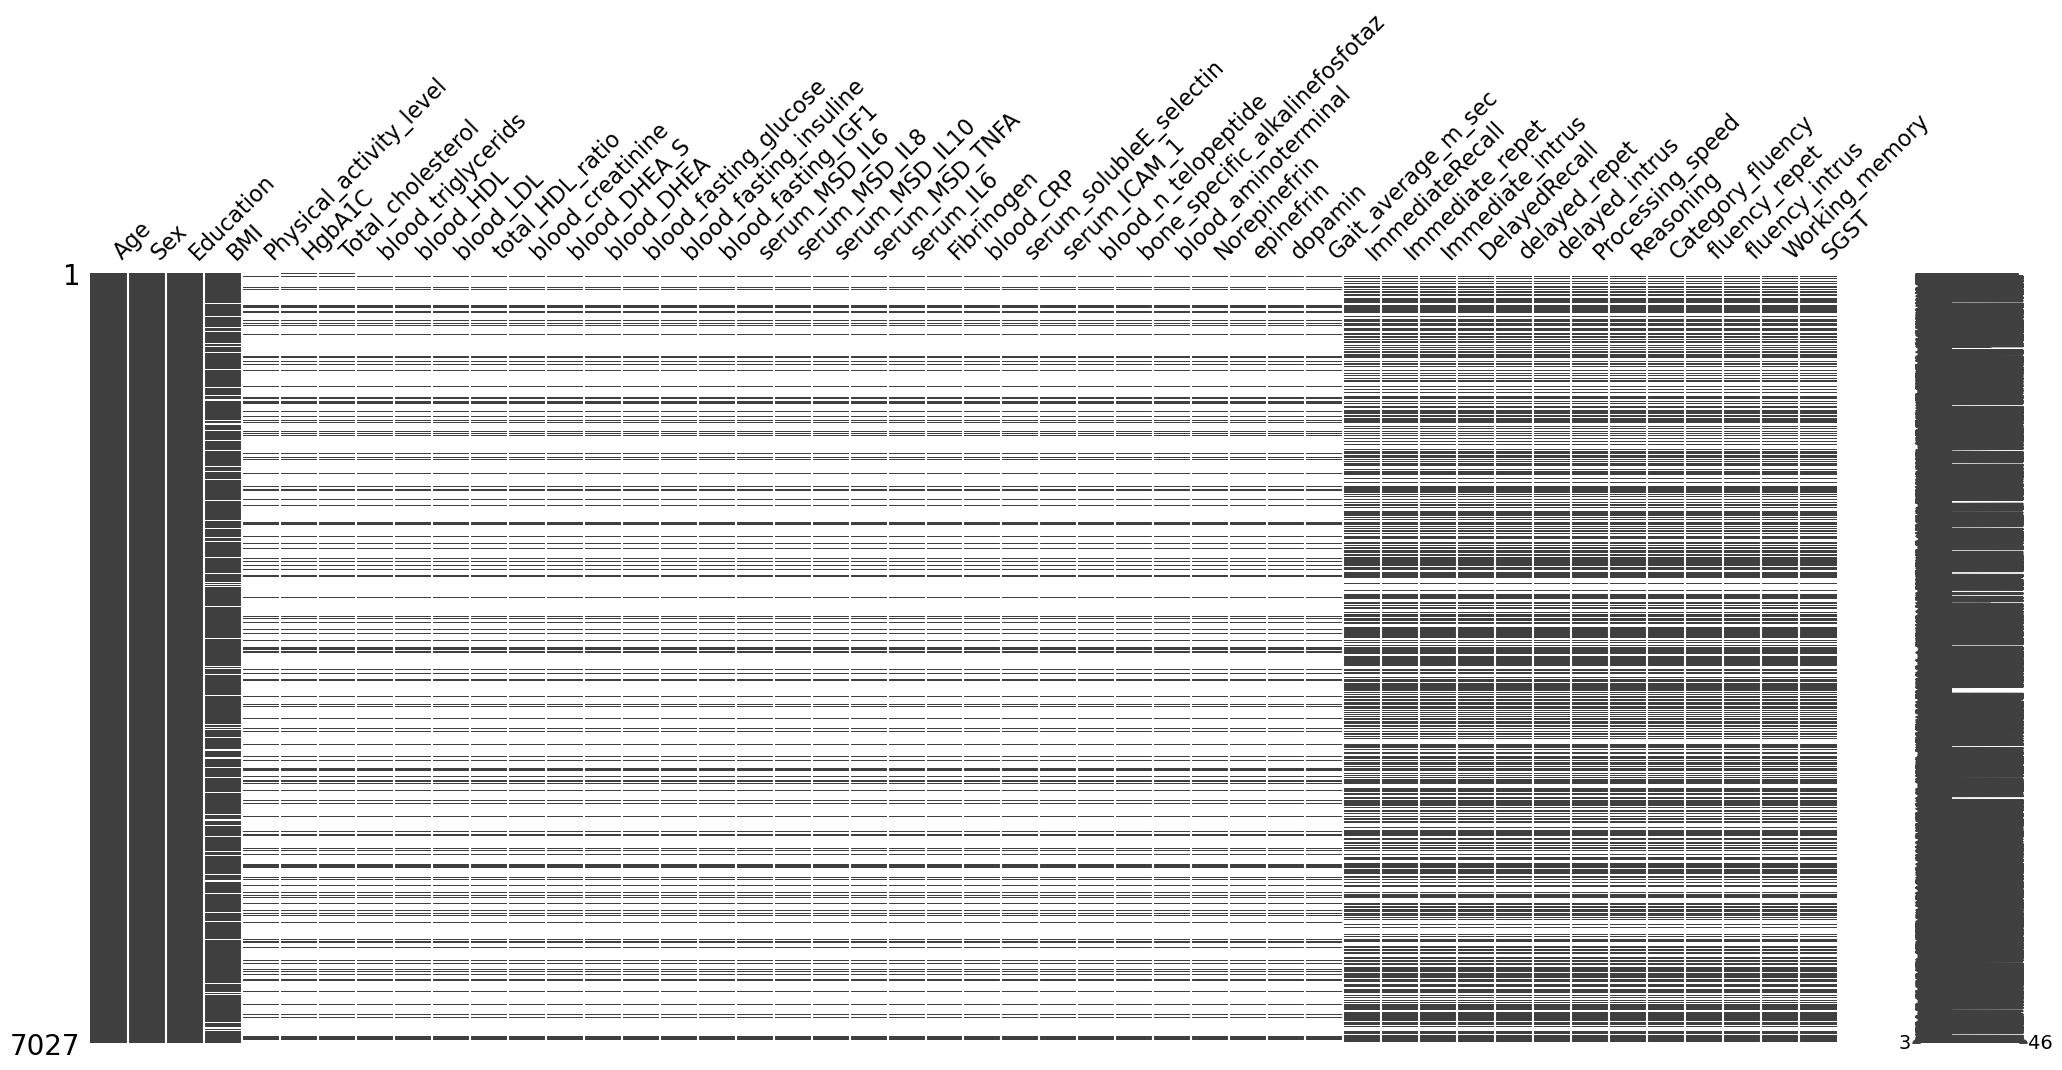

In [7]:
import missingno as msno
%matplotlib inline
msno.matrix(train_df)
plt.show()

There are many missing values. But our target will be Gait_average_m_sec. Let's start with dropping missing values on Gait_average_m_sec.

In [8]:
train_df = train_df.dropna(subset=['Gait_average_m_sec'])

Let's observe missing values again.

In [9]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

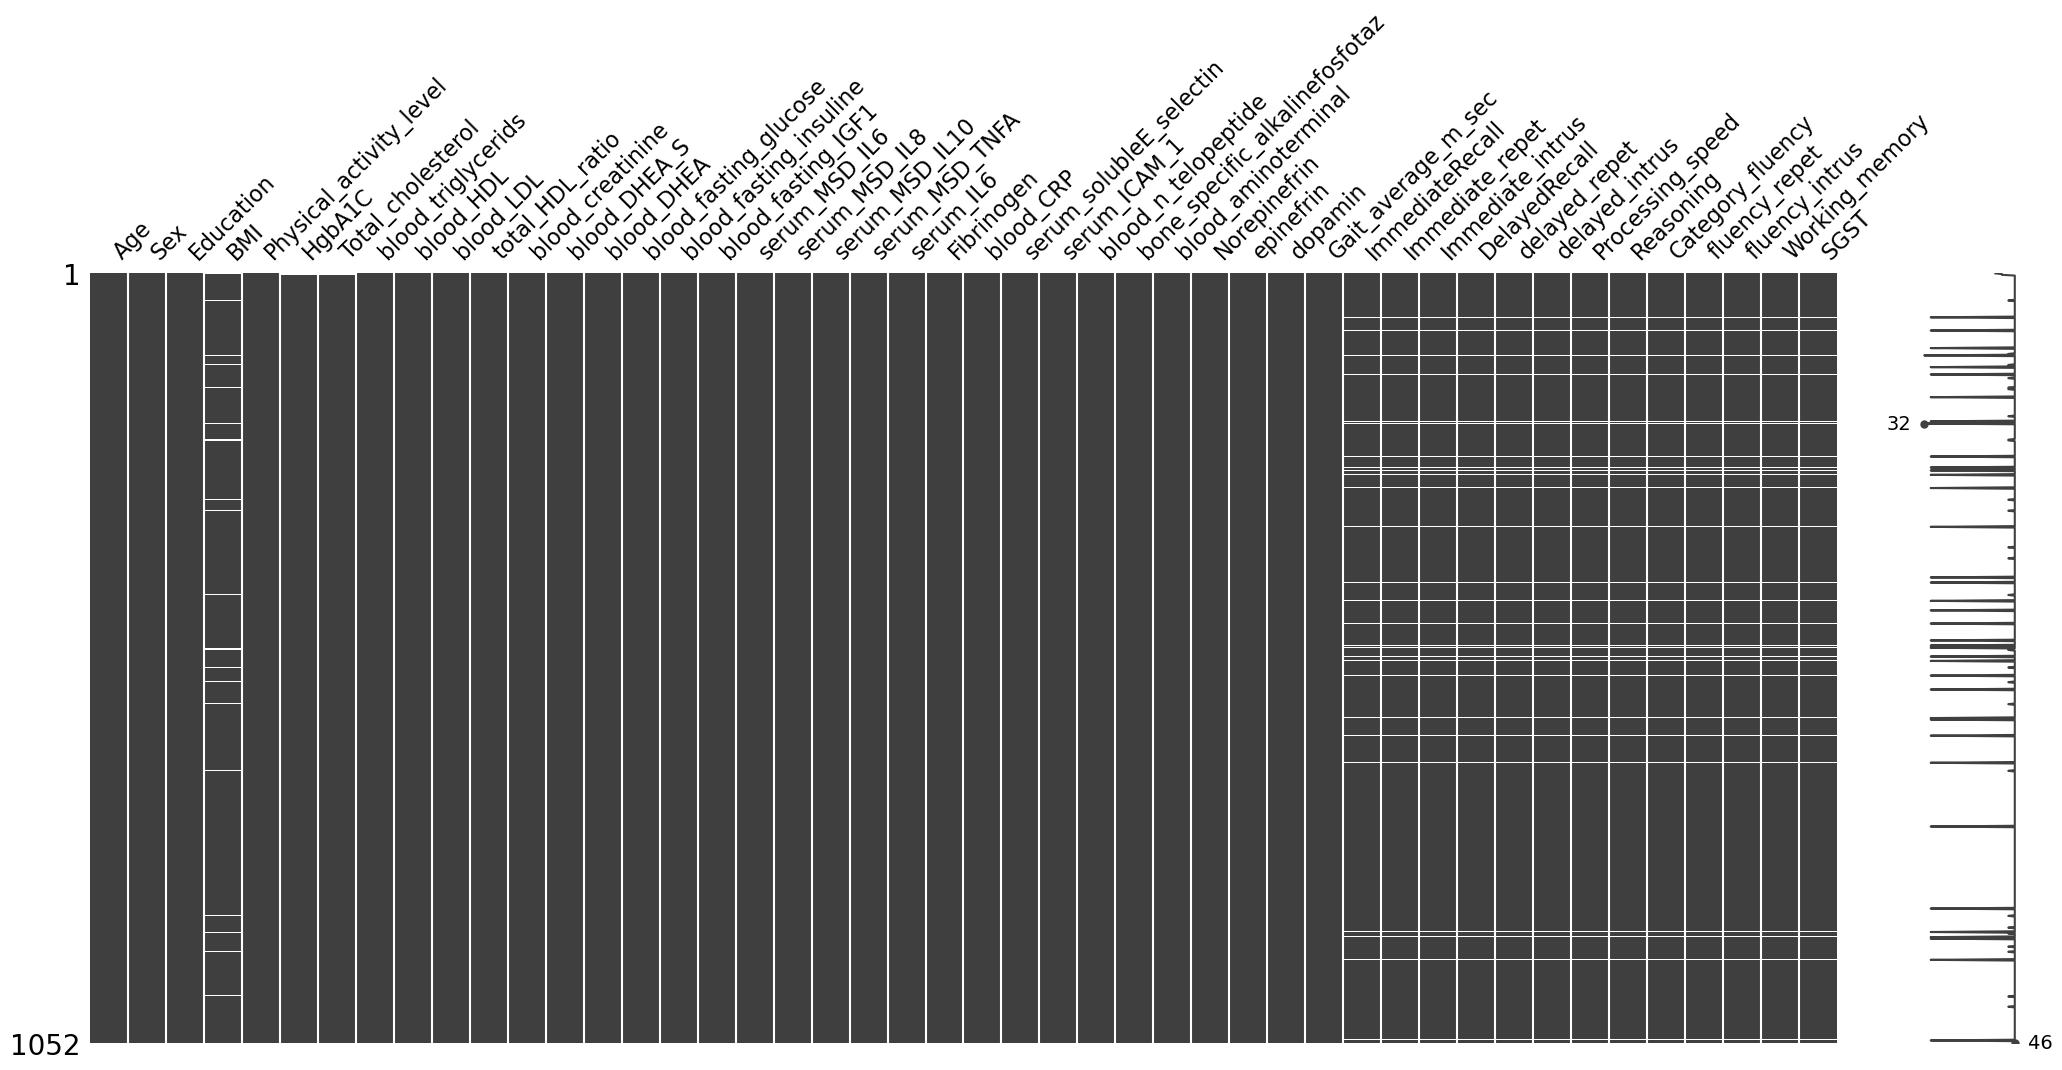

In [10]:
msno.matrix(train_df)
plt.show()

There are records that we have no cognitive data. I will also drop them.

In [11]:
train_df = train_df.dropna(subset=['Immediate_repet'])

In [12]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["percent"] = missing[0:] / 7108 *100
missing.style.background_gradient('viridis')

<Axes: >

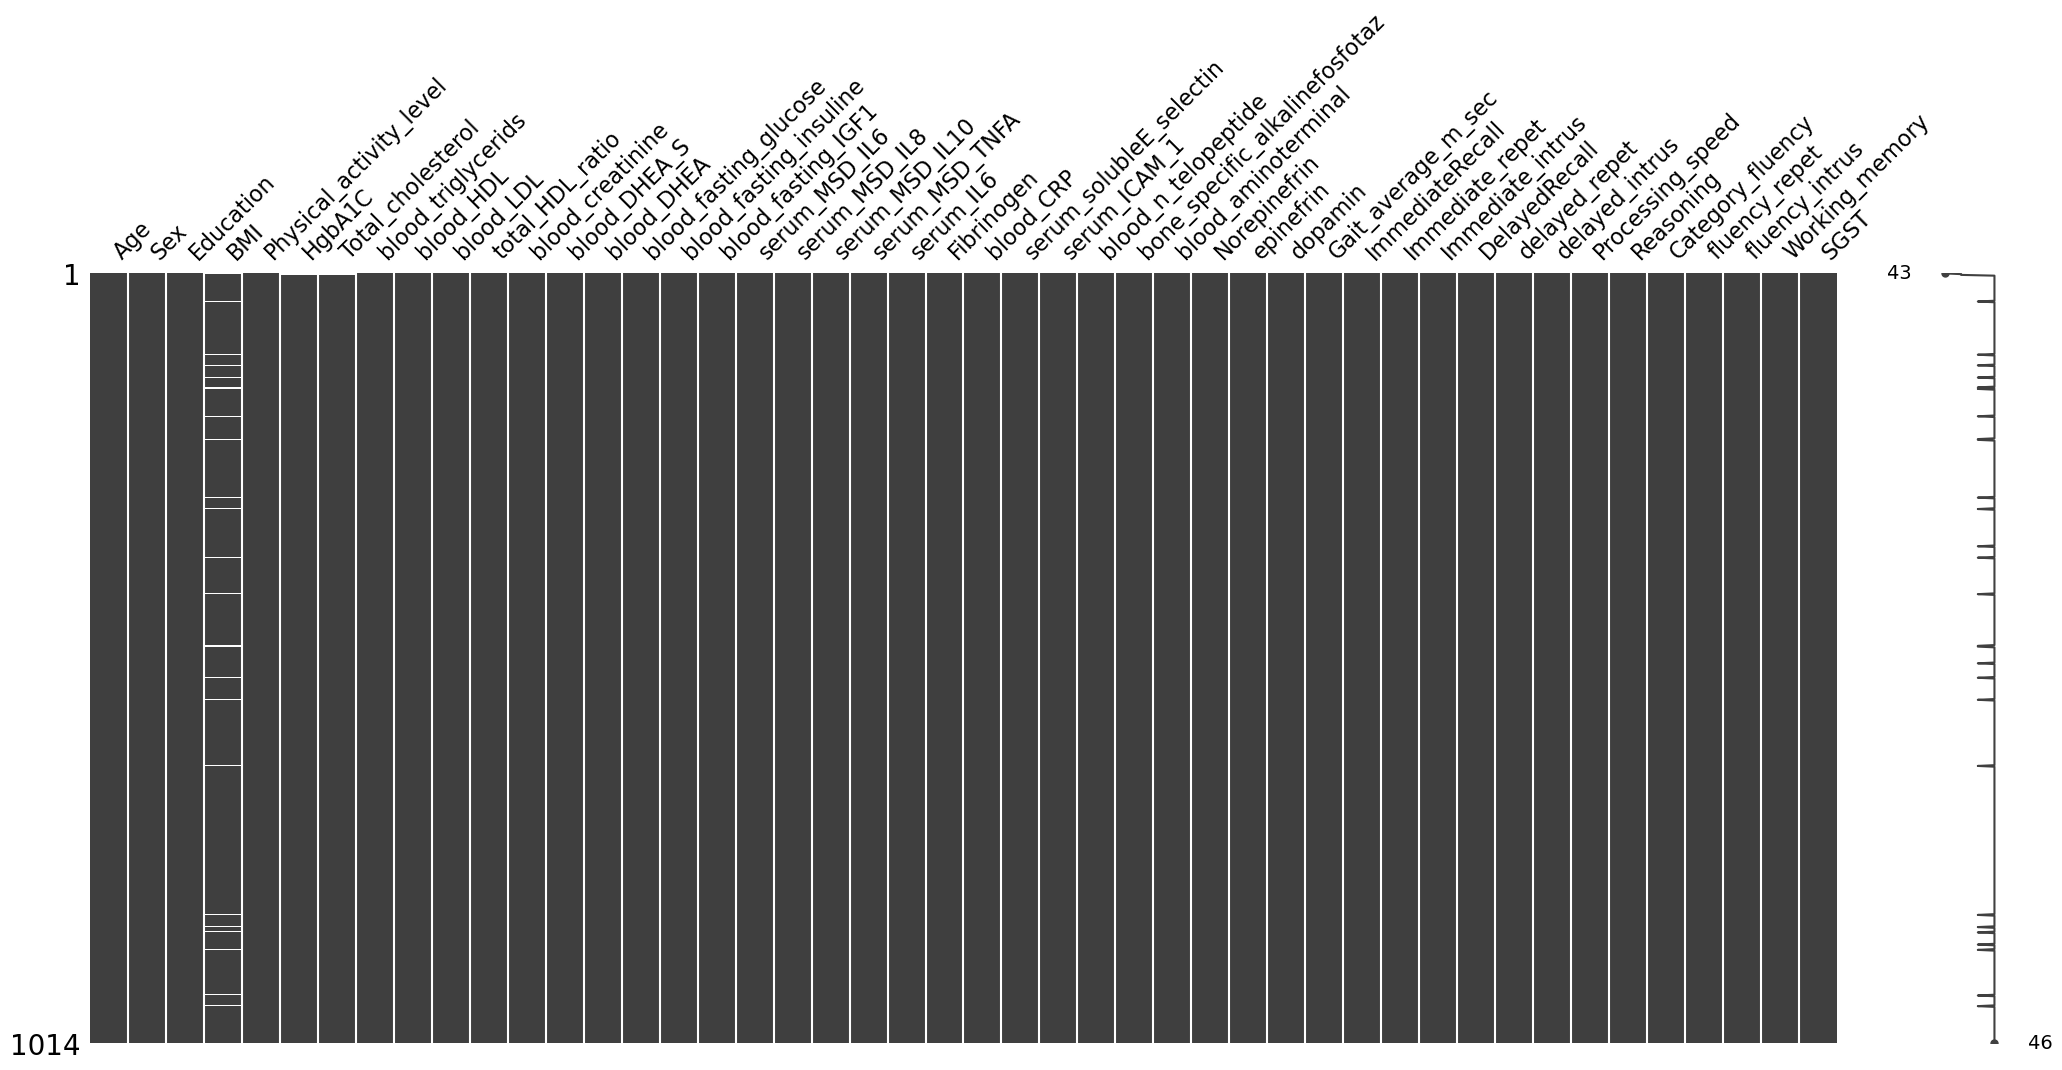

In [13]:
msno.matrix(train_df)

There are still some missing values on BMI. But we already dropped many records. We can impute them if required. Three-based algorithms handle missing data I will try them first. 

## Descpriptive statistics

In [14]:
#numerical feature descriptive statistics
train_df.describe().T

count         mean          std        min  \
Age                             1014.0    46.402367    11.830150  25.000000   
Education                       1014.0     7.655819     3.717157   2.000000   
BMI                              986.0    29.294109    14.795500   9.440000   
Physical_activity_level         1014.0  1877.569576  7218.147183   0.000000   
HgbA1C                          1011.0     7.261776    10.886320   3.800000   
Total_cholesterol               1011.0   194.248269    85.859652  91.000000   
blood_triglycerids              1014.0   222.682446   936.219798  25.000000   
blood_HDL                       1014.0    64.707101    99.399480  19.000000   
blood_LDL                       1014.0   116.029586    98.737175  16.000000   
total_HDL_ratio                 1014.0     4.786509     9.950820   1.340000   
blood_creatinine                1014.0     1.741026     9.211850   0.500000   
blood_DHEA_S                    1014.0   117.253353   128.838218   0.900000   
blood_DHEA                      1014.0     7.078039    11.255792   0.400000   
blood_fasting_glucose           1014.0   113.446746   111.237385   5.000000   
blood_fasting_insuline          1014.0    27.318540   119.710749   1.000000   
blood_fasting_IGF1              1014.0   139.621302   116.523085  18.000000   
serum_MSD_IL6                   1014.0    13.053205   108.033643   0.110000   
serum_MSD_IL8                   1014.0    25.553964   107.352437   3.750000   
serum_MSD_IL10                  1014.0     1.550355    10.779533   0.050000   
serum_MSD_TNFA                  1014.0     3.372485    10.476573   0.310000   
serum_IL6                       1014.0     3.753635     9.917680   0.160000   
Fibrinogen                      1014.0   349.309665   113.404633  45.000000   
blood_CRP                       1014.0     4.024061    11.994229   0.034060   
serum_solubleE_selectin         1014.0    50.952022    96.934171   0.090000   
serum_ICAM_1                    1014.0   383.851252   965.219025  44.000000   
blood_n_telopeptide             1014.0    14.835187    10.765854   2.040000   
bone_specific_alkalinefosfotaz  1014.0    36.933393    96.650020   3.030000   
blood_aminoterminal             1014.0    65.547002    97.424591   7.250000   
Norepinefrin                    1014.0     3.160020    10.545010   0.230000   
epinefrin                       1014.0     1.789850    12.608430   0.009000   
dopamin                         1014.0    12.097791    12.212753   0.170000   
Gait_average_m_sec              1014.0     1.030100     0.599376   0.524934   
ImmediateRecall                 1014.0     7.177515     5.380493   1.000000   
Immediate_repet                 1014.0     0.515779     5.346000   0.000000   
Immediate_intrus                1014.0     0.768245     5.360502   0.000000   
DelayedRecall                   1014.0     7.418146    16.269652   0.000000   
delayed_repet                   1014.0     3.095661    16.866286   0.000000   
delayed_intrus                  1014.0     3.833333    16.779531   0.000000   
Processing_speed                1014.0    39.049310    10.952177  11.000000   
Reasoning                       1014.0     2.515779     1.520264   0.000000   
Category_fluency                1014.0    19.774162     5.852521   5.000000   
fluency_repet                   1014.0     0.313609     0.639496   0.000000   
fluency_intrus                  1014.0     0.047337     0.643694   0.000000   
Working_memory                  1014.0     5.112426     3.233766   0.000000   
SGST                            1014.0     3.457911    14.731106   0.676000   

                                      25%         50%          75%  \
Age                              37.00000   45.500000    55.000000   
Education                         5.00000    8.000000     9.000000   
BMI                              23.15350   26.083000    29.843250   
Physical_activity_level         180.00000  720.000000  1800.000000   
HgbA1C                            5.59780    5.8

There are many strange values on MAX column. I think these are not real measurements. They may be corrupted or missing records. Let's grab them and have a closer look.

In [15]:
contains_strange_values = train_df[train_df.isin([98, 99, 999, 998, 9999,9998]).any(axis=1)]

contains_strange_values.head(10).style.background_gradient('Reds')

Many records include 98, 99, 999, 998, 9999, 9998. I will change their value to nan. 

I did not touch any 98, 99, 999, 998, 9999, or 9998 values if it is a reasonable value within the features range. For example, I did not touch the 98 or 99 value on blood_fasting_glucose but changed the 999 to none.

In [16]:
train_df['BMI'] = train_df['BMI'].replace(99.000000, np.nan)
train_df['BMI'] = train_df['BMI'].replace(98.000000, np.nan)

train_df['Physical_activity_level'] = train_df['Physical_activity_level'].replace(99998.000000, np.nan)

train_df['Education'] = train_df['Education'].replace(97.000000, np.nan)


train_df['HgbA1C'] = train_df['HgbA1C'].replace(99.000000, np.nan)
train_df['HgbA1C'] = train_df['HgbA1C'].replace(98.000000, np.nan)

train_df['Total_cholesterol'] = train_df['Total_cholesterol'].replace(999.000000, np.nan)
train_df['Total_cholesterol'] = train_df['Total_cholesterol'].replace(998.000000, np.nan)

train_df['blood_triglycerids'] = train_df['blood_triglycerids'].replace(9999.000000, np.nan)
train_df['blood_triglycerids'] = train_df['blood_triglycerids'].replace(9998.000000, np.nan)

train_df['blood_HDL'] = train_df['blood_HDL'].replace(999.000000, np.nan)
train_df['blood_HDL'] = train_df['blood_HDL'].replace(998.000000, np.nan)

train_df['blood_LDL'] = train_df['blood_LDL'].replace(999.000000, np.nan)
train_df['blood_LDL'] = train_df['blood_LDL'].replace(998.000000, np.nan)

train_df['total_HDL_ratio'] = train_df['total_HDL_ratio'].replace(99.000000, np.nan)
train_df['total_HDL_ratio'] = train_df['total_HDL_ratio'].replace(98.000000, np.nan)

train_df['blood_creatinine'] = train_df['blood_creatinine'].replace(99.000000, np.nan)
train_df['blood_creatinine'] = train_df['blood_creatinine'].replace(98.000000, np.nan)

train_df['blood_DHEA_S'] = train_df['blood_DHEA_S'].replace(999.000000, np.nan)
train_df['blood_DHEA_S'] = train_df['blood_DHEA_S'].replace(998.000000, np.nan)

train_df['blood_DHEA'] = train_df['blood_DHEA'].replace(99.000000, np.nan)
train_df['blood_DHEA'] = train_df['blood_DHEA'].replace(98.000000, np.nan)

train_df['blood_fasting_glucose'] = train_df['blood_fasting_glucose'].replace(999.000000, np.nan)
train_df['blood_fasting_glucose'] = train_df['blood_fasting_glucose'].replace(998.000000, np.nan)

train_df['blood_fasting_insuline'] = train_df['blood_fasting_insuline'].replace(999.000000, np.nan)
train_df['blood_fasting_insuline'] = train_df['blood_fasting_insuline'].replace(998.000000, np.nan)

train_df['blood_fasting_IGF1'] = train_df['blood_fasting_IGF1'].replace(999.000000, np.nan)
train_df['blood_fasting_IGF1'] = train_df['blood_fasting_IGF1'].replace(998.000000, np.nan)

train_df['serum_MSD_IL6'] = train_df['serum_MSD_IL6'].replace(999.000000, np.nan)
train_df['serum_MSD_IL6'] = train_df['serum_MSD_IL6'].replace(998.000000, np.nan)

train_df['serum_MSD_IL8'] = train_df['serum_MSD_IL8'].replace(999.000000, np.nan)
train_df['serum_MSD_IL8'] = train_df['serum_MSD_IL8'].replace(998.000000, np.nan)

train_df['serum_MSD_IL10'] = train_df['serum_MSD_IL10'].replace(99.000000, np.nan)
train_df['serum_MSD_IL10'] = train_df['serum_MSD_IL10'].replace(98.000000, np.nan)

train_df['serum_MSD_TNFA'] = train_df['serum_MSD_TNFA'].replace(99.000000, np.nan)
train_df['serum_MSD_TNFA'] = train_df['serum_MSD_TNFA'].replace(98.000000, np.nan)

train_df['serum_IL6'] = train_df['serum_IL6'].replace(99.000000, np.nan)
train_df['serum_IL6'] = train_df['serum_IL6'].replace(98.000000, np.nan)

train_df['Fibrinogen'] = train_df['Fibrinogen'].replace(999.000000, np.nan)
train_df['Fibrinogen'] = train_df['Fibrinogen'].replace(998.000000, np.nan)

train_df['blood_CRP'] = train_df['blood_CRP'].replace(99.000000, np.nan)
train_df['blood_CRP'] = train_df['blood_CRP'].replace(98.000000, np.nan)

train_df['serum_solubleE_selectin'] = train_df['serum_solubleE_selectin'].replace(999.000000, np.nan)
train_df['serum_solubleE_selectin'] = train_df['serum_solubleE_selectin'].replace(998.000000, np.nan)

train_df['serum_ICAM_1'] = train_df['serum_ICAM_1'].replace(9999.000000, np.nan)
train_df['serum_ICAM_1'] = train_df['serum_ICAM_1'].replace(9998.000000, np.nan)

train_df['blood_n_telopeptide'] = train_df['blood_n_telopeptide'].replace(99.000000, np.nan)
train_df['blood_n_telopeptide'] = train_df['blood_n_telopeptide'].replace(98.000000, np.nan)

train_df['bone_specific_alkalinefosfotaz'] = train_df['bone_specific_alkalinefosfotaz'].replace(999.000000, np.nan)
train_df['bone_specific_alkalinefosfotaz'] = train_df['bone_specific_alkalinefosfotaz'].replace(998.000000, np.nan)

train_df['blood_aminoterminal'] = train_df['blood_aminoterminal'].replace(999.000000, np.nan)
train_df['blood_aminoterminal'] = train_df['blood_aminoterminal'].replace(998.000000, np.nan)

train_df['Norepinefrin'] = train_df['Norepinefrin'].replace(99.000000, np.nan)
train_df['Norepinefrin'] = train_df['Norepinefrin'].replace(98.000000, np.nan)

train_df['epinefrin'] = train_df['epinefrin'].replace(99.000000, np.nan)
train_df['epinefrin'] = train_df['epinefrin'].replace(98.000000, np.nan)

train_df['dopamin'] = train_df['dopamin'].replace(99.000000, np.nan)
train_df['dopamin'] = train_df['dopamin'].replace(98.000000, np.nan)

train_df['ImmediateRecall'] = train_df['ImmediateRecall'].replace(98.000000, np.nan)
train_df['ImmediateRecall'] = train_df['ImmediateRecall'].replace(99.000000, np.nan)

train_df['Immediate_repet'] = train_df['Immediate_repet'].replace(98.000000, np.nan)
train_df['Immediate_repet'] = train_df['Immediate_repet'].replace(99.000000, np.nan)

train_df['Immediate_intrus'] = train_df['Immediate_intrus'].replace(98.000000, np.nan)
train_df['Immediate_intrus'] = train_df['Immediate_intrus'].replace(99.000000, np.nan)

train_df['DelayedRecall'] = train_df['DelayedRecall'].replace(98.000000, np.nan)
train_df['DelayedRecall'] = train_df['DelayedRecall'].replace(99.000000, np.nan)

train_df['delayed_repet'] = train_df['delayed_repet'].replace(98.000000, np.nan)
train_df['delayed_repet'] = train_df['delayed_repet'].replace(99.000000, np.nan)

train_df['delayed_intrus'] = train_df['delayed_intrus'].replace(98.000000, np.nan)
train_df['delayed_intrus'] = train_df['delayed_intrus'].replace(99.000000, np.nan)

train_df['Working_memory'] = train_df['Working_memory'].replace(98.000000, np.nan)
train_df['Working_memory'] = train_df['Working_memory'].replace(99.000000, np.nan)

train_df['SGST'] = train_df['SGST'].replace(98.000000, np.nan)
train_df['SGST'] = train_df['SGST'].replace(99.000000, np.nan)



Let's count missing values again.. 

In [17]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

<Axes: >

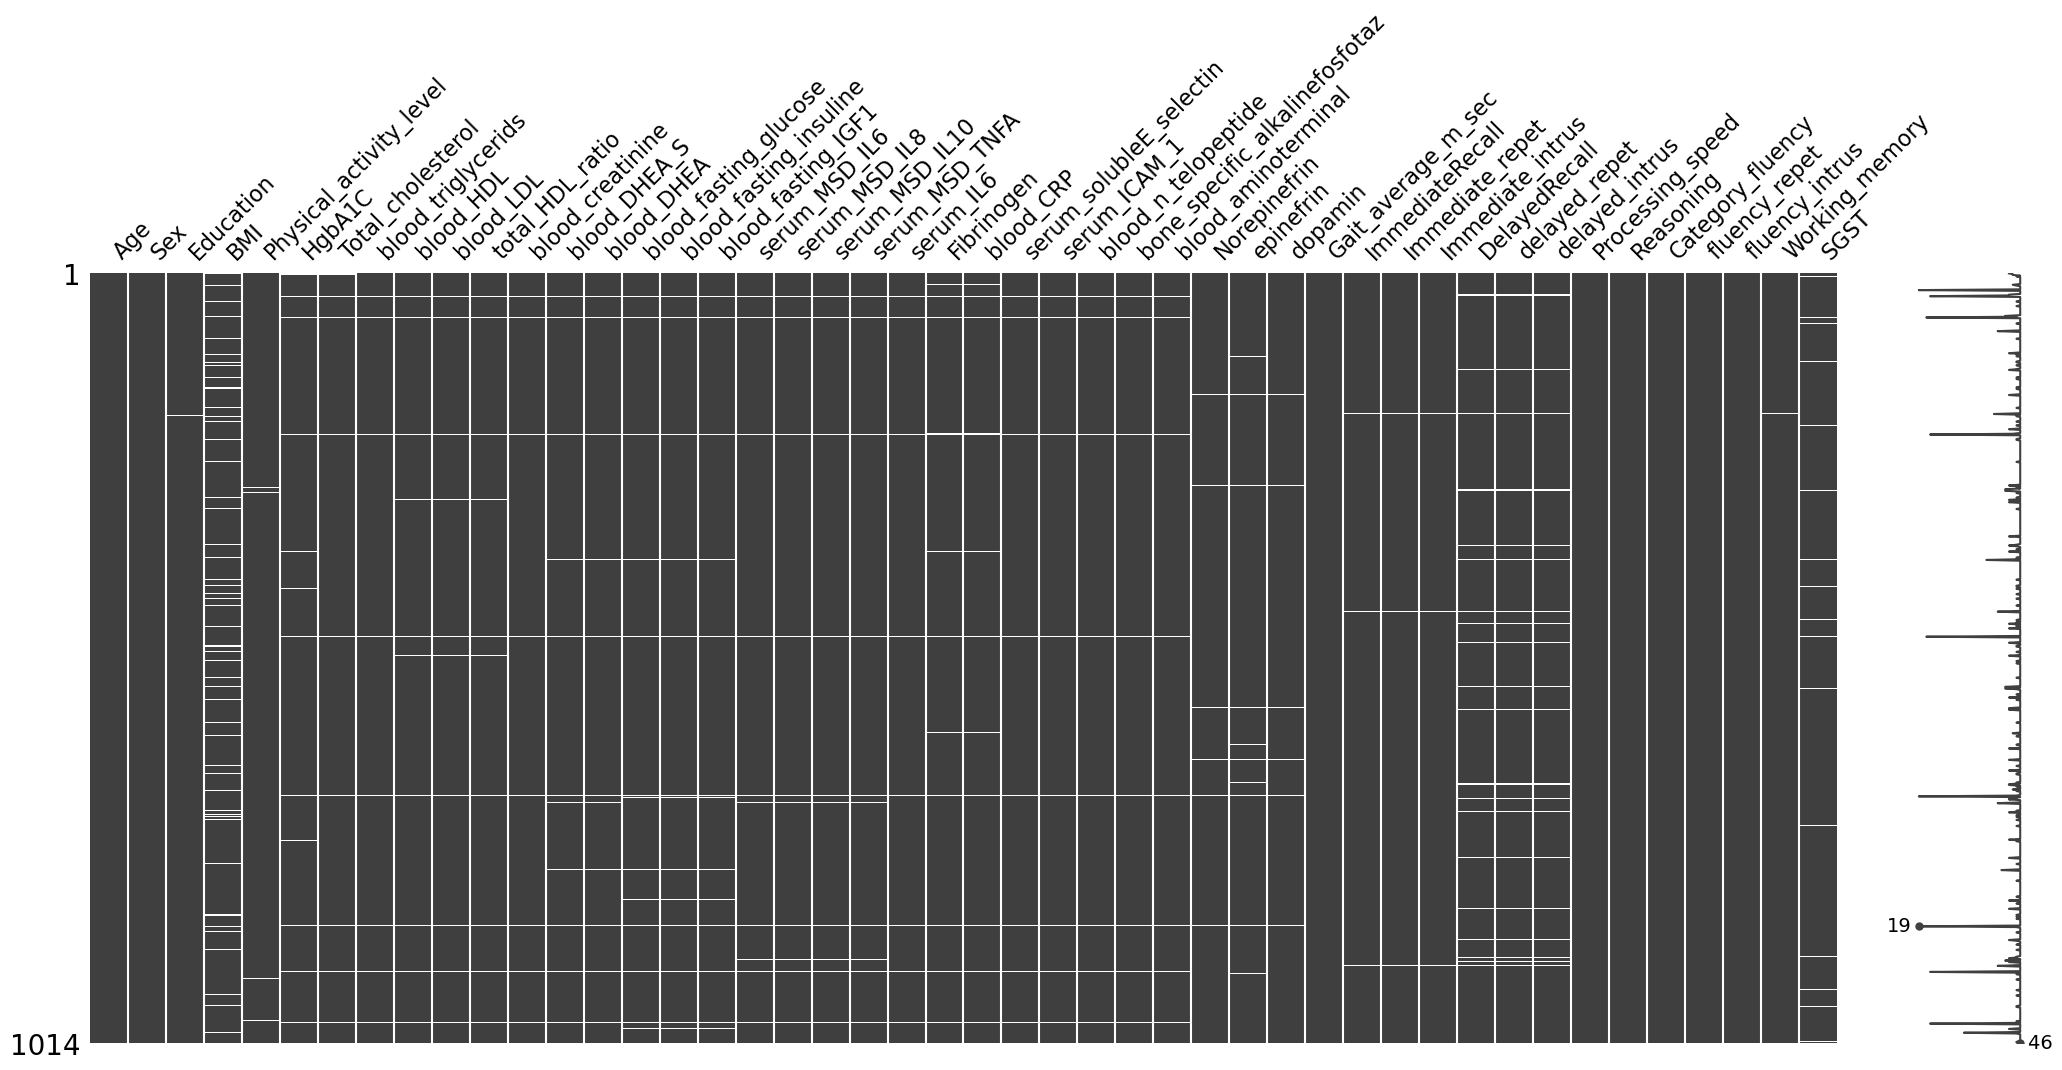

In [18]:
msno.matrix(train_df)

I will further drop the samples that have many missing values. (I dropped observations that contain more than 5 missing features)

In [19]:
train_df['number_of_NaNs'] = train_df.isna().sum(1)
rows_to_drop = train_df.loc[train_df['number_of_NaNs']>= 5]


In [20]:
indexes_drop = rows_to_drop.index
train_df = train_df.drop(indexes_drop, axis=0)


In [21]:
train_df = train_df.drop('number_of_NaNs', axis=1)


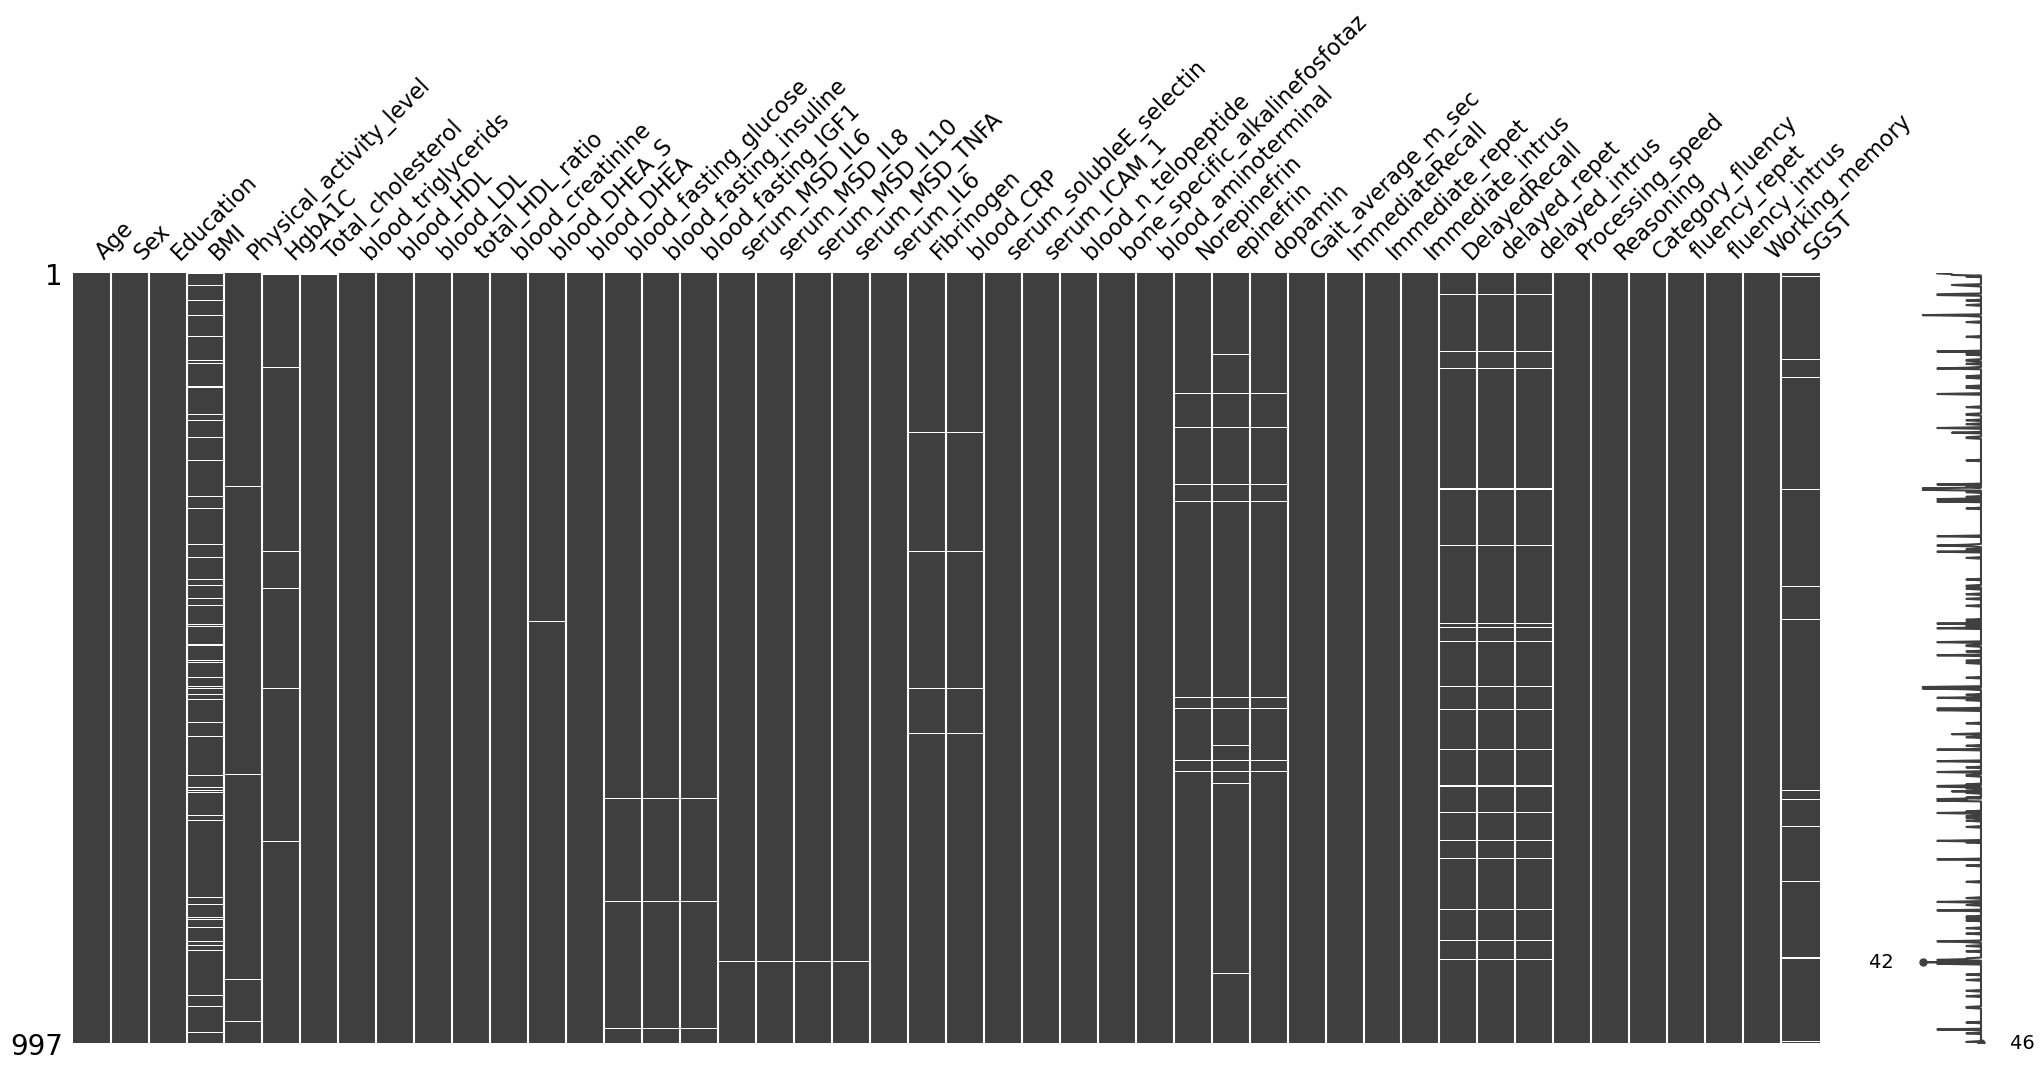

In [22]:
msno.matrix(train_df)
plt.show()

This is the final data that I will start analysis. 

We have 997 samples. There are still some missing values. But I will impute them if required.

Let's repeat descriptive statistics with clean data.

In [23]:
#numerical feature descriptive statistics
train_df.describe().T

count         mean          std        min  \
Age                             997.0    46.390171    11.841966  25.000000   
Education                       996.0     7.560241     2.440320   2.000000   
BMI                             931.0    26.456091     4.980032   9.440000   
Physical_activity_level         992.0  1384.921421  2078.279857   0.000000   
HgbA1C                          989.0     5.979447     0.884908   3.800000   
Total_cholesterol               994.0   186.934608    39.510203  91.000000   
blood_triglycerids              997.0   135.151454   141.675495  25.000000   
blood_HDL                       995.0    54.482412    17.471864  19.000000   
blood_LDL                       995.0   106.247236    34.737579  16.000000   
total_HDL_ratio                 995.0     3.752794     1.404701   1.340000   
blood_creatinine                997.0     0.870913     0.255455   0.500000   
blood_DHEA_S                    996.0   104.887450    75.841160   0.900000   
blood_DHEA                      997.0     5.883437     4.133735   0.400000   
blood_fasting_glucose           994.0   100.153924    24.694823   5.000000   
blood_fasting_insuline          994.0    12.738431    12.432294   1.000000   
blood_fasting_IGF1              994.0   126.671026    50.298099  18.000000   
serum_MSD_IL6                   996.0     1.251114     4.929747   0.110000   
serum_MSD_IL8                   996.0    13.918745    13.172348   3.750000   
serum_MSD_IL10                  996.0     0.386817     1.729297   0.050000   
serum_MSD_TNFA                  996.0     2.232118     0.845711   0.310000   
serum_IL6                       997.0     2.808722     2.834524   0.160000   
Fibrinogen                      992.0   340.108871    84.057932  45.000000   
blood_CRP                       992.0     2.687699     4.305169   0.034060   
serum_solubleE_selectin         997.0    41.532427    20.994271   0.090000   
serum_ICAM_1                    997.0   288.049930    99.958957  44.000000   
blood_n_telopeptide             997.0    13.996961     6.775862   2.040000   
bone_specific_alkalinefosfotaz  997.0    27.354203    10.704536   3.030000   
blood_aminoterminal             997.0    56.218415    28.423415   7.250000   
Norepinefrin                    989.0     2.014459     1.563497   0.230000   
epinefrin                       984.0     0.144564     0.118117   0.009000   
dopamin                         989.0    11.065784     7.799927   0.170000   
Gait_average_m_sec              997.0     1.013770     0.525332   0.524934   
ImmediateRecall                 997.0     6.909729     2.113229   1.000000   
Immediate_repet                 997.0     0.221665     0.587702   0.000000   
Immediate_intrus                997.0     0.481444     0.812124   0.000000   
DelayedRecall                   971.0     4.561277     2.426466   0.000000   
delayed_repet                   971.0     0.104016     0.396498   0.000000   
delayed_intrus                  971.0     0.870237     1.304097   0.000000   
Processing_speed                997.0    39.073220    10.984822  11.000000   
Reasoning                       997.0     2.517553     1.512645   0.000000   
Category_fluency                997.0    19.773320     5.832223   5.000000   
fluency_repet                   997.0     0.318957     0.643606   0.000000   
fluency_intrus                  997.0     0.048144     0.649134   0.000000   
Working_memory                  997.0     5.026078     1.393949   0.000000   
SGST                            976.0     1.165359     0.333665   0.676000   

                                      25%         50%          75%  \
Age                              37.00000   45.000000    55.000000   
Education                         5.00000    8.000000     9.000000   
BMI                              22.86100   25.825000    29.200000   
Physical_activity_level         173.25000  720.000000  1758.000000   
HgbA1C                            5.59780    5.800000     6.115400   
Total_cholesterol      

A clear observation is that there are some strong outliers on target varaible Gait_average_m_sec. Let's make a visualization.

<Axes: xlabel='Gait_average_m_sec', ylabel='Count'>

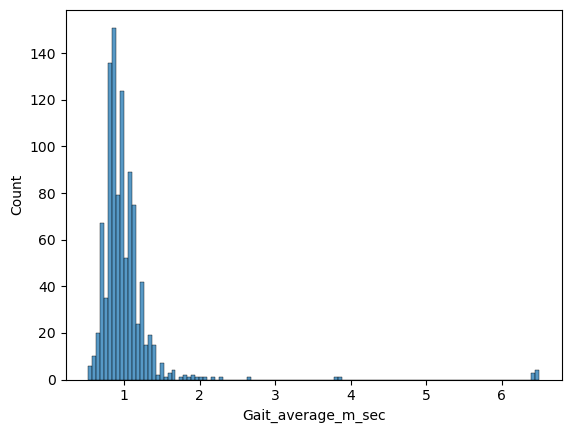

In [24]:
 sns.histplot(x='Gait_average_m_sec',  data=train_df )

There are outliers at the higher end. These observations may severely affect machine learning model performance. Let's look at those samples to see if they are legitimate samples.

In [25]:
gait_avarage_outliers = train_df.loc[train_df['Gait_average_m_sec']>= 2]

gait_avarage_outliers.style.background_gradient('Reds')

Some of these samples contains largest values on a specific columns. I noted them below. 

* 14283: reasoning 5.000000
* 15944: dopamin 45, blood_CRP 61.700000
* 16705: SGST 6.322000
* 17400: Working memory 8
* 17647: Working memory 8, dopamin 45 
* 18679: reasoning 5.000000

Here I will drop these samples. Note that this is an important decision since this decision will affect machine learning models performance significantly. If you think these are valid samples we may need to reconsider.


In [26]:
indexes_drop = gait_avarage_outliers.index
train_df = train_df.drop(indexes_drop, axis=0)

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 10002 to 19193
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Age                             983 non-null    int64   
 1   Sex                             983 non-null    category
 2   Education                       982 non-null    float64 
 3   BMI                             921 non-null    float64 
 4   Physical_activity_level         978 non-null    float64 
 5   HgbA1C                          976 non-null    float64 
 6   Total_cholesterol               980 non-null    float64 
 7   blood_triglycerids              983 non-null    float64 
 8   blood_HDL                       981 non-null    float64 
 9   blood_LDL                       981 non-null    float64 
 10  total_HDL_ratio                 981 non-null    float64 
 11  blood_creatinine                983 non-null    float64 
 12  blood_DHEA_S    

Let's calculate descriptive stats one more time.

In [28]:
#numerical feature descriptive statistics
train_df.describe().T

count         mean          std        min  \
Age                             983.0    46.215666    11.737379  25.000000   
Education                       982.0     7.551935     2.442165   2.000000   
BMI                             921.0    26.446593     4.971295   9.440000   
Physical_activity_level         978.0  1401.586452  2088.094825   0.000000   
HgbA1C                          976.0     5.977528     0.889817   3.800000   
Total_cholesterol               980.0   186.910204    39.677094  91.000000   
blood_triglycerids              983.0   135.344863   142.371141  25.000000   
blood_HDL                       981.0    54.363914    17.439607  19.000000   
blood_LDL                       981.0   106.316004    34.819096  16.000000   
total_HDL_ratio                 981.0     3.759154     1.405357   1.340000   
blood_creatinine                983.0     0.871414     0.255861   0.500000   
blood_DHEA_S                    982.0   105.634318    76.017372   0.900000   
blood_DHEA                      983.0     5.910334     4.146560   0.400000   
blood_fasting_glucose           980.0   100.176531    24.828121   5.000000   
blood_fasting_insuline          980.0    12.761224    12.437633   1.000000   
blood_fasting_IGF1              980.0   126.639796    50.203385  18.000000   
serum_MSD_IL6                   982.0     1.236935     4.958270   0.110000   
serum_MSD_IL8                   982.0    13.890479    13.251436   3.750000   
serum_MSD_IL10                  982.0     0.387862     1.741521   0.050000   
serum_MSD_TNFA                  982.0     2.227749     0.838779   0.310000   
serum_IL6                       983.0     2.777148     2.794114   0.160000   
Fibrinogen                      979.0   339.508682    83.777304  45.000000   
blood_CRP                       979.0     2.599589     3.808412   0.034060   
serum_solubleE_selectin         983.0    41.352838    20.893557   0.090000   
serum_ICAM_1                    983.0   287.415331   100.062098  44.000000   
blood_n_telopeptide             983.0    13.957833     6.700115   2.040000   
bone_specific_alkalinefosfotaz  983.0    27.287152    10.593936   3.030000   
blood_aminoterminal             983.0    56.227009    28.368660   7.250000   
Norepinefrin                    976.0     2.011527     1.555734   0.230000   
epinefrin                       971.0     0.144738     0.118575   0.009000   
dopamin                         976.0    11.012971     7.620362   0.170000   
Gait_average_m_sec              983.0     0.962992     0.203536   0.524934   
ImmediateRecall                 983.0     6.923703     2.100644   1.000000   
Immediate_repet                 983.0     0.219736     0.585411   0.000000   
Immediate_intrus                983.0     0.481180     0.811954   0.000000   
DelayedRecall                   958.0     4.563674     2.398104   0.000000   
delayed_repet                   958.0     0.105428     0.398995   0.000000   
delayed_intrus                  958.0     0.862213     1.301800   0.000000   
Processing_speed                983.0    39.166836    10.980108  11.000000   
Reasoning                       983.0     2.525941     1.510684   0.000000   
Category_fluency                983.0    19.805697     5.791690   5.000000   
fluency_repet                   983.0     0.318413     0.644052   0.000000   
fluency_intrus                  983.0     0.048830     0.653719   0.000000   
Working_memory                  983.0     5.031536     1.389524   0.000000   
SGST                            963.0     1.159607     0.290020   0.676000   

                                      25%         50%          75%  \
Age                              37.00000   45.000000    55.000000   
Education                         5.00000    8.000000     9.000000   
BMI                              22.85900   25.825000    29.170000   
Physical_activity_level         180.00000  720.000000  1797.000000   
HgbA1C                            5.59780    5.800000     6.115400   
Total_cholesterol      

I will discretize the target (Gait_average_m_sec) as below average and above average.
* Class 1 indicates below-average
* Class 0 indicated above-average

In [29]:
# Gait_average_m_sec mean is 0.962992
train_df['Gait_average_low'] = (train_df['Gait_average_m_sec'] < 0.962992 ).astype(int)

In [30]:
train_df[['Gait_average_m_sec','Gait_average_low']]

Gait_average_m_sec  Gait_average_low
ID                                         
10002            0.984252                 0
10005            0.984252                 0
10019            0.787402                 1
10040            0.853018                 1
10047            0.787402                 1
...                   ...               ...
19157            0.984252                 0
19175            0.820210                 1
19181            0.984252                 0
19190            0.656168                 1
19193            0.853018                 1

[983 rows x 2 columns]

In [31]:
#drop original column
train_df =  train_df.drop(['Gait_average_m_sec'], axis=1)

Let's observe target distribution

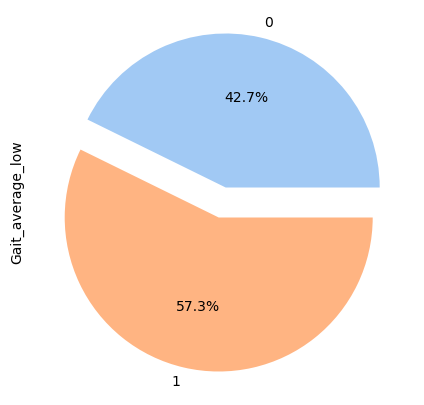

In [32]:
#Target Distribution
plt.figure(figsize=(5,5))
palette_color = sns.color_palette('pastel')
explode = [0.1, 0.1]
train_df.groupby('Gait_average_low')['Gait_average_low'].count().plot.pie(colors=palette_color,explode=explode, autopct="%1.1f%%");

57.3% of samples are below average. 42.7% of samples are above average. 
These values also represent a baseline for a dummy classifier. 

(A dummy classifier that always says gait_avarage is below mean will have a 57.3% accuracy. We will need to beat this for a reasonable model)

## Grouping features for preprocessing purposes

Different data types will require different preprocessing techniques. Here, I will group features for bookkeeping and preprocessing purposes.

In [33]:
train_df.nunique().sort_values()

Gait_average_low                    2
Sex                                 2
fluency_repet                       4
fluency_intrus                      5
delayed_repet                       5
Immediate_repet                     5
Reasoning                           6
Immediate_intrus                    7
Working_memory                      8
delayed_intrus                     10
Education                          11
ImmediateRecall                    13
DelayedRecall                      15
blood_creatinine                   18
Category_fluency                   35
Age                                49
blood_fasting_insuline             58
Processing_speed                   63
epinefrin                          77
blood_HDL                          86
blood_fasting_glucose              99
serum_MSD_IL10                    101
HgbA1C                            107
Norepinefrin                      134
blood_LDL                         165
Total_cholesterol                 185
blood_fastin

In [34]:
# Just bookkeeping
feature_list = [feature for feature in train_df.columns if not feature  == "Gait_average_low"]
categorical_features = [feature for feature in train_df.columns if 
                        train_df[feature].dtype == "category"] 
numerical_features = [feature for feature in train_df.columns if 
                      feature not in categorical_features + ['Gait_average_low']]

discrete_features = ['fluency_repet', 'fluency_intrus','Immediate_repet','delayed_repet','Reasoning','Immediate_intrus','Working_memory']

continuous_features = list(set(numerical_features) - set(discrete_features))

assert feature_list.sort() == (categorical_features + numerical_features).sort()
assert numerical_features.sort() == (continuous_features + discrete_features).sort()


<a id = "4"></a><br>
# Exploratory Data Analysis

Let's observe features with respect to target.

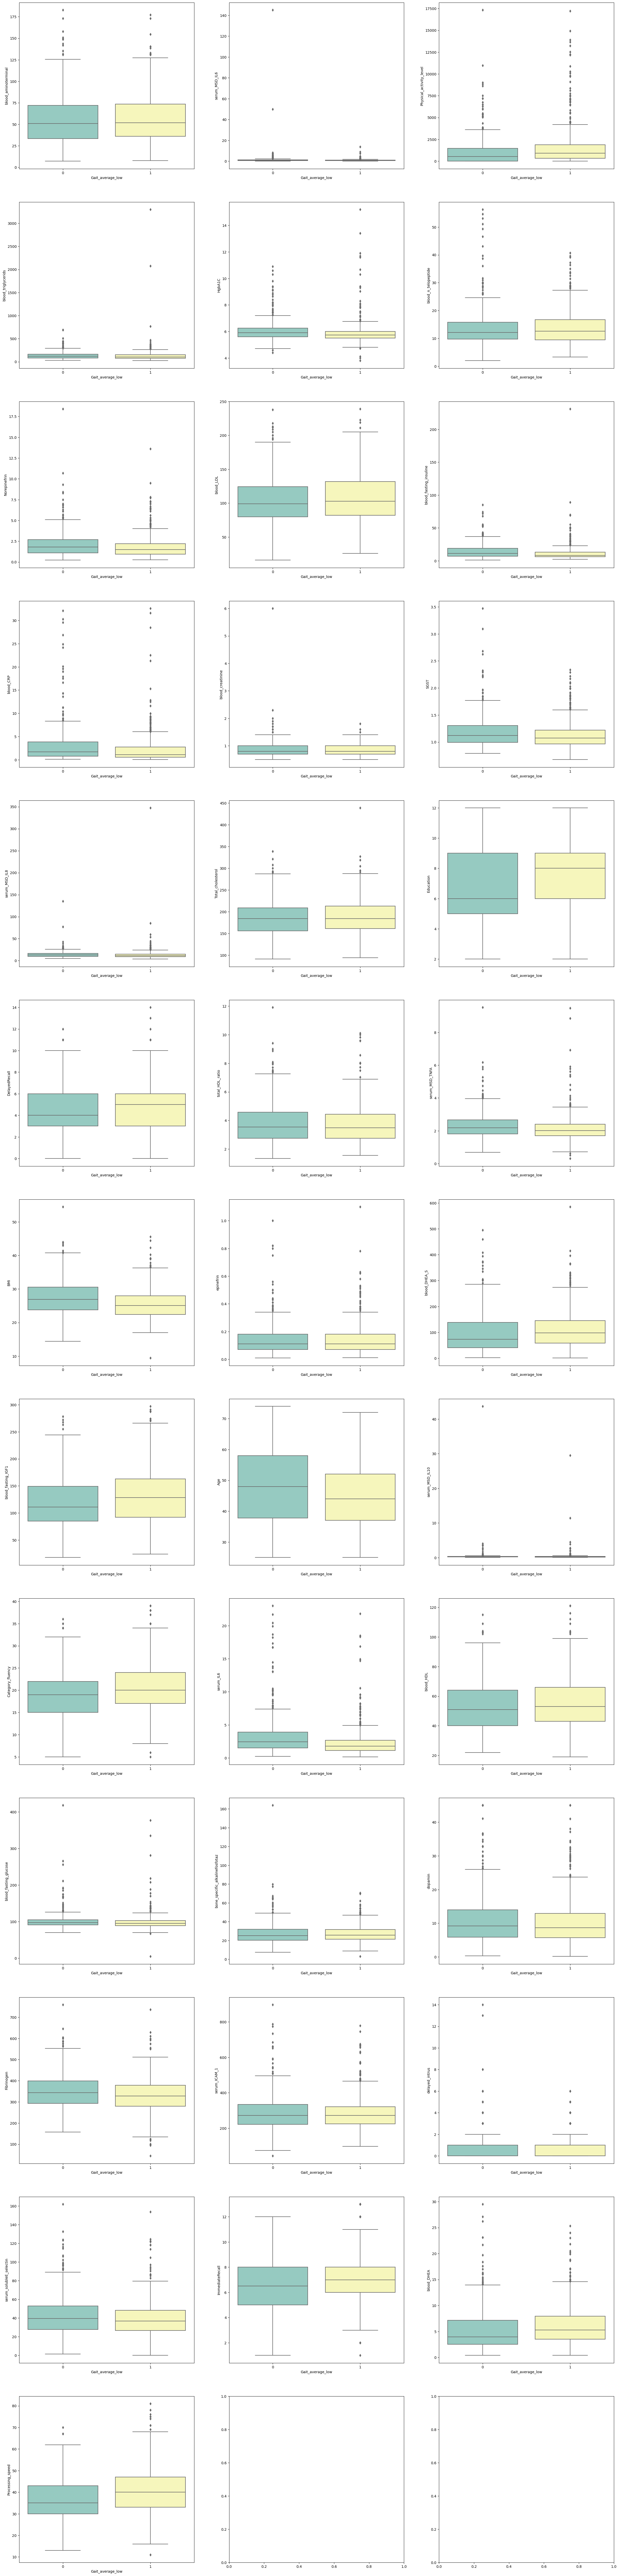

In [35]:
fig, ax = plt.subplots(13, 3, figsize=(30, 130))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x='Gait_average_low', y=var, data=train_df, ax=subplot, palette='Set3')

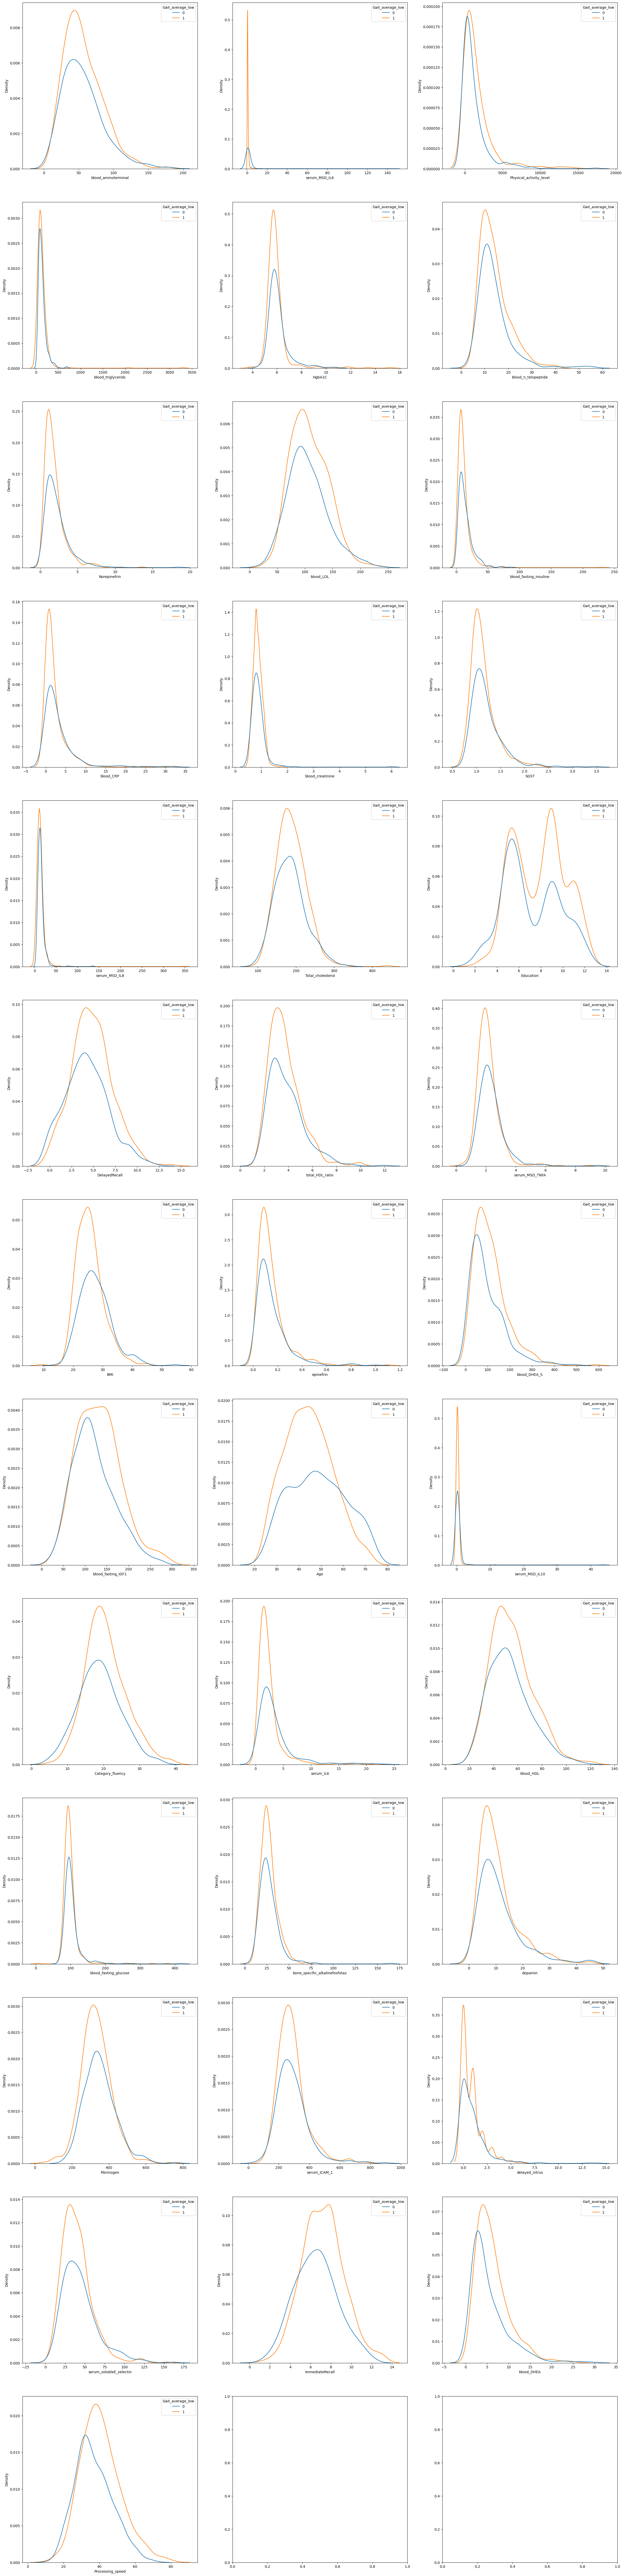

In [36]:
fig, ax = plt.subplots(13, 3, figsize=(30, 130))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.kdeplot(x=var,  data=train_df, ax=subplot, hue='Gait_average_low' )

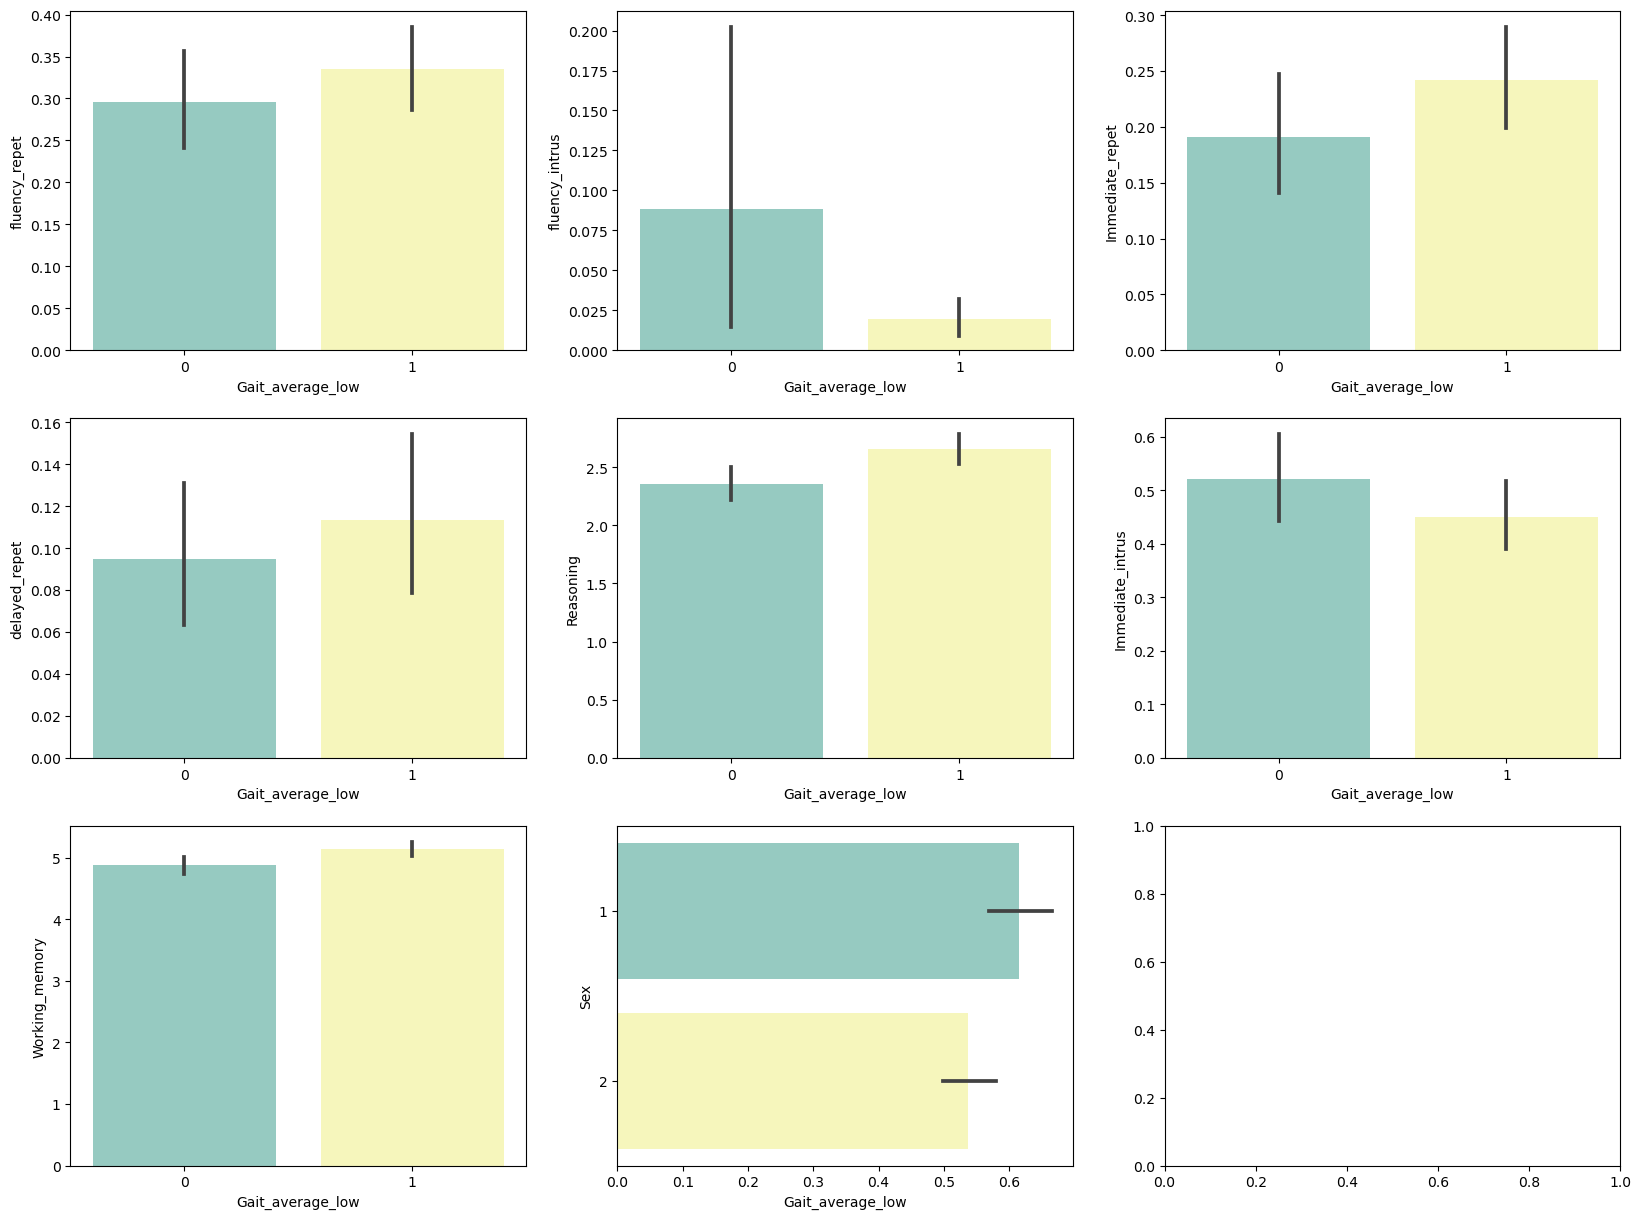

In [37]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for var, subplot in zip(discrete_features + categorical_features, ax.flatten()):
    sns.barplot(x='Gait_average_low', y= var, data=train_df, ax=subplot, palette='Set3')

Let's look at the relationship between features and the target more quantitatively...

Correlation is not a good measure for classification problems. 

(It is good at measuring linear relations between continuous variables, but our target is discrete)

Let's check mutual information, which measures this kind of relationship well.


In [38]:
y = train_df.Gait_average_low

In [39]:
# determine the mutual information for numerical features
#You need to fill missing values to get results from mutual_info_classif function
mutual_df = train_df[numerical_features ]

mutual_info = mutual_info_classif(mutual_df.fillna(mutual_df.mean()), y, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")


We have weak relations... A sign that we will not get a perfect model. But I will try my best..

In [40]:
no_info_cols = mutual_info[mutual_info['Numerical_Feature_MI'] < 0.00001].index.values.tolist()
no_info_cols

['blood_LDL',
 'delayed_intrus',
 'bone_specific_alkalinefosfotaz',
 'fluency_repet',
 'serum_ICAM_1',
 'Physical_activity_level',
 'serum_MSD_IL10',
 'Total_cholesterol',
 'serum_MSD_IL8',
 'serum_MSD_TNFA',
 'serum_solubleE_selectin',
 'fluency_intrus']

In [41]:
#Dropping no info columns generally helps. But did not help here.
#train_df = train_df.drop(no_info_cols, axis=1)

Mutual information also work with preprocessed categorical variables.

In [42]:
mutual_df_categorical = train_df[categorical_features]
#categorical features must be encoded to get mutual information
for colname in mutual_df_categorical:
    mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()
mutual_info = mutual_info_classif(mutual_df_categorical, y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_categorical.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Categorical_Feature_MI"] ).style.background_gradient("cool")


Sex will not be a discriminative feature...

<a id = "4"></a><br>
# Modeling and hyperparameter tuning

%80 of the data is used for training, and 10-fold cross-validation is performed. %20 percent of the data is reserved as a test set for model evaluation. 

In [43]:
y = train_df['Gait_average_low']
train_df = train_df.drop(['Gait_average_low'], axis=1)
train_df = pd.get_dummies(train_df)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, 
                                                    test_size=0.2,
                                                    random_state=random_state,
                                                    shuffle=True,
                                                    stratify=y)


print(X_train.shape, X_test.shape)

(786, 46) (197, 46)


Tree-based boosting algorithms generally perform well with tabular data sets. I will use XGBoost as a baseline here.

I will also use Optuna package for hyperparameter tuning. It uses Bayesian optimization to optimize the hyperparameters. 

In [45]:
import xgboost as xgb

def objective(trial):

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical =True)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "error",
        "booster": "dart",
        #"booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 0.5),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.8),

    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-3, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-3, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-5, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-5, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-error")
    history = xgb.cv(param,
                     dtrain,
                     stratified= True,
                     nfold=10,
                     num_boost_round=10000,
                     early_stopping_rounds=50,
                     seed = random_state,
                     callbacks=[pruning_callback])

    mean_error = history["test-error-mean"].values[-1]
    trial.set_user_attr("n_estimators", len(history))
    return mean_error


if __name__ == "__main__":
    sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
    study = optuna.create_study( sampler=sampler, pruner=pruner, direction="minimize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

[I 2023-12-21 15:44:32,255] A new study created in memory with name: no-name-0ddfa656-e07f-475f-ab9f-688eccc8fd48
[I 2023-12-21 15:44:40,031] Trial 0 finished with value: 0.3599480688088283 and parameters: {'lambda': 9.915644566638385e-06, 'alpha': 0.40338008326003827, 'subsample': 0.4195981825434215, 'colsample_bytree': 0.5993292420985183, 'max_depth': 2, 'eta': 0.0029375384576328283, 'gamma': 0.0014936568554617625, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00011526449540315612, 'skip_drop': 8.111941985431919e-05}. Best is trial 0 with value: 0.3599480688088283.
[I 2023-12-21 15:44:47,437] Trial 1 finished with value: 0.34837715027588445 and parameters: {'lambda': 2.9324868872723725e-07, 'alpha': 2.716051144654844e-06, 'subsample': 0.35742692948967136, 'colsample_bytree': 0.5159725093210579, 'max_depth': 3, 'eta': 0.06847920095574778, 'gamma': 0.002621087878265439, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_ty

[I 2023-12-21 15:46:29,918] Trial 33 finished with value: 0.33953261927945466 and parameters: {'lambda': 1.8561759342931318e-05, 'alpha': 0.8424467774664457, 'subsample': 0.3710445288377953, 'colsample_bytree': 0.44024742026274166, 'max_depth': 4, 'eta': 0.012631558845645267, 'gamma': 0.33185700666417695, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0019371351339271463, 'skip_drop': 4.3707923964203745e-05}. Best is trial 8 with value: 0.33591366439467707.
[I 2023-12-21 15:46:30,360] Trial 34 pruned. Trial was pruned at iteration 10.
[I 2023-12-21 15:46:30,770] Trial 35 pruned. Trial was pruned at iteration 10.
[I 2023-12-21 15:46:31,202] Trial 36 pruned. Trial was pruned at iteration 10.
[I 2023-12-21 15:46:31,566] Trial 37 pruned. Trial was pruned at iteration 10.
[I 2023-12-21 15:46:41,091] Trial 38 pruned. Trial was pruned at iteration 87.
[I 2023-12-21 15:46:41,456] Trial 39 pruned. Trial was pruned at iteration 11.
[I 2023-12-21

[I 2023-12-21 15:49:53,929] Trial 92 pruned. Trial was pruned at iteration 10.
[I 2023-12-21 15:50:06,631] Trial 93 finished with value: 0.3421291788380396 and parameters: {'lambda': 4.16854235087035e-06, 'alpha': 0.6307984933449385, 'subsample': 0.381587565037629, 'colsample_bytree': 0.3272218943252594, 'max_depth': 2, 'eta': 0.015193858235098053, 'gamma': 0.8460025093389915, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00032251814135031225, 'skip_drop': 0.0001444142826896511}. Best is trial 61 with value: 0.3344206426484907.
[I 2023-12-21 15:50:15,573] Trial 94 finished with value: 0.3433787731256086 and parameters: {'lambda': 1.6228961809931742e-05, 'alpha': 0.6535220571939196, 'subsample': 0.3818531614484649, 'colsample_bytree': 0.3370439286966114, 'max_depth': 2, 'eta': 0.016187934005037503, 'gamma': 0.6933171371383755, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.000351349655

Number of finished trials: 100
Best trial:
  Value: 0.3344206426484907
  Params: 
    lambda: 1.7087270734881614e-05
    alpha: 0.42034948750591417
    subsample: 0.3766966576426426
    colsample_bytree: 0.4464738539905791
    max_depth: 3
    eta: 0.01240411207367914
    gamma: 0.9889089522073509
    grow_policy: lossguide
    sample_type: weighted
    normalize_type: forest
    rate_drop: 0.0016767195847857729
    skip_drop: 5.809635477428658e-05
  Number of estimators: 151


In [46]:
plot_optimization_history(study)

In [47]:
plot_param_importances(study)

In [48]:
xgb_optuna_params ={'booster': 'dart', 'lambda': 1.7087270734881614e-05, 'alpha': 0.42034948750591417, 'subsample': 0.3766966576426426, 'colsample_bytree': 0.4464738539905791, 'max_depth': 3, 'eta': 0.01240411207367914, 'gamma': 0.9889089522073509, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0016767195847857729, 'skip_drop': 5.809635477428658e-05}

In [49]:
xgb_model = XGBClassifier(**xgb_optuna_params,n_estimators = 151, random_state=random_state,eval_metric='error', objective = "binary:logistic")
xgb_model = xgb_model.fit(X_train, y_train)


In [50]:
test_accuracy = round(xgb_model.score(X_test,y_test)*100,2)
print("Testing Accuracy: % {}".format(test_accuracy))


Testing Accuracy: % 70.05


We have an accuracy of 66.6% on cross-validation. And 70.0% on the test set.
* It's not great, but higher than then dummy classifier baseline (57.3%)

Let's observe confusion matrix.

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

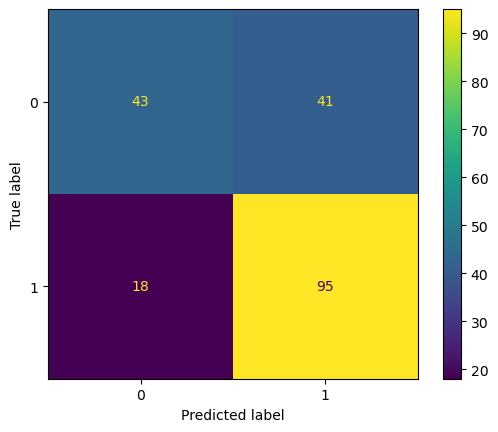

In [52]:
y_pred = xgb_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

Our model is good at classifying below-average samples. But poor performance on above-average samples.

Let's also obsere AUC metric. A receiver operating characteristic curve, or ROC-AUC curve, is a graphical plot that illustrates the performance of a binary classifier model  at varying probability threshold values.

In [53]:
from sklearn.metrics import RocCurveDisplay


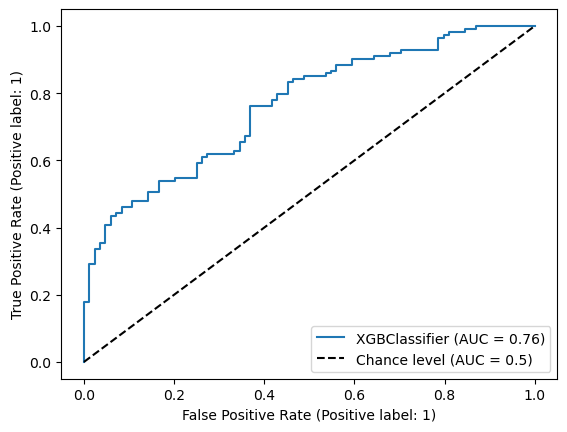

In [54]:
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test, plot_chance_level=True)

Another usefull plot is the feature importance plot. It shows which columns are played important role during decision processes. XGBoost has a built in plot_importance function. Let's plot feature importances.

In [55]:
from xgboost import plot_importance


In [56]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

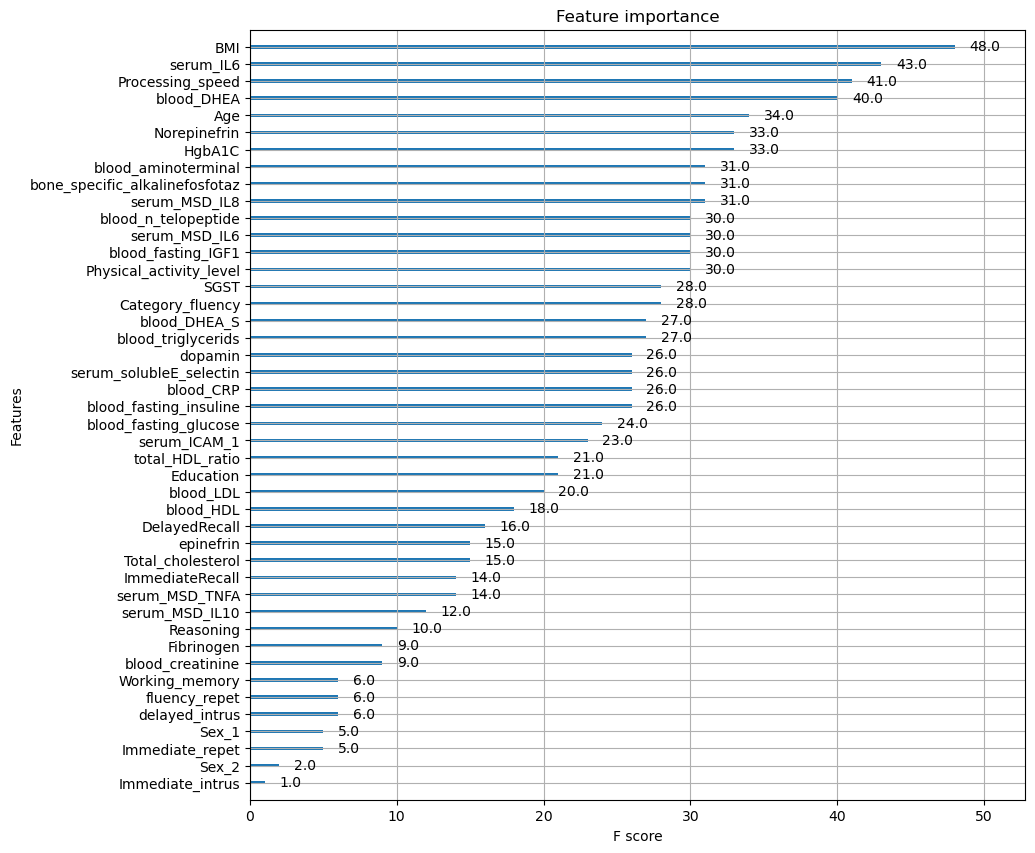

In [57]:
my_plot_importance(xgb_model,figsize = (10,10))


Yellowbrick is a good library for model evaluation visualizations. Let's see a model evaluation summary.

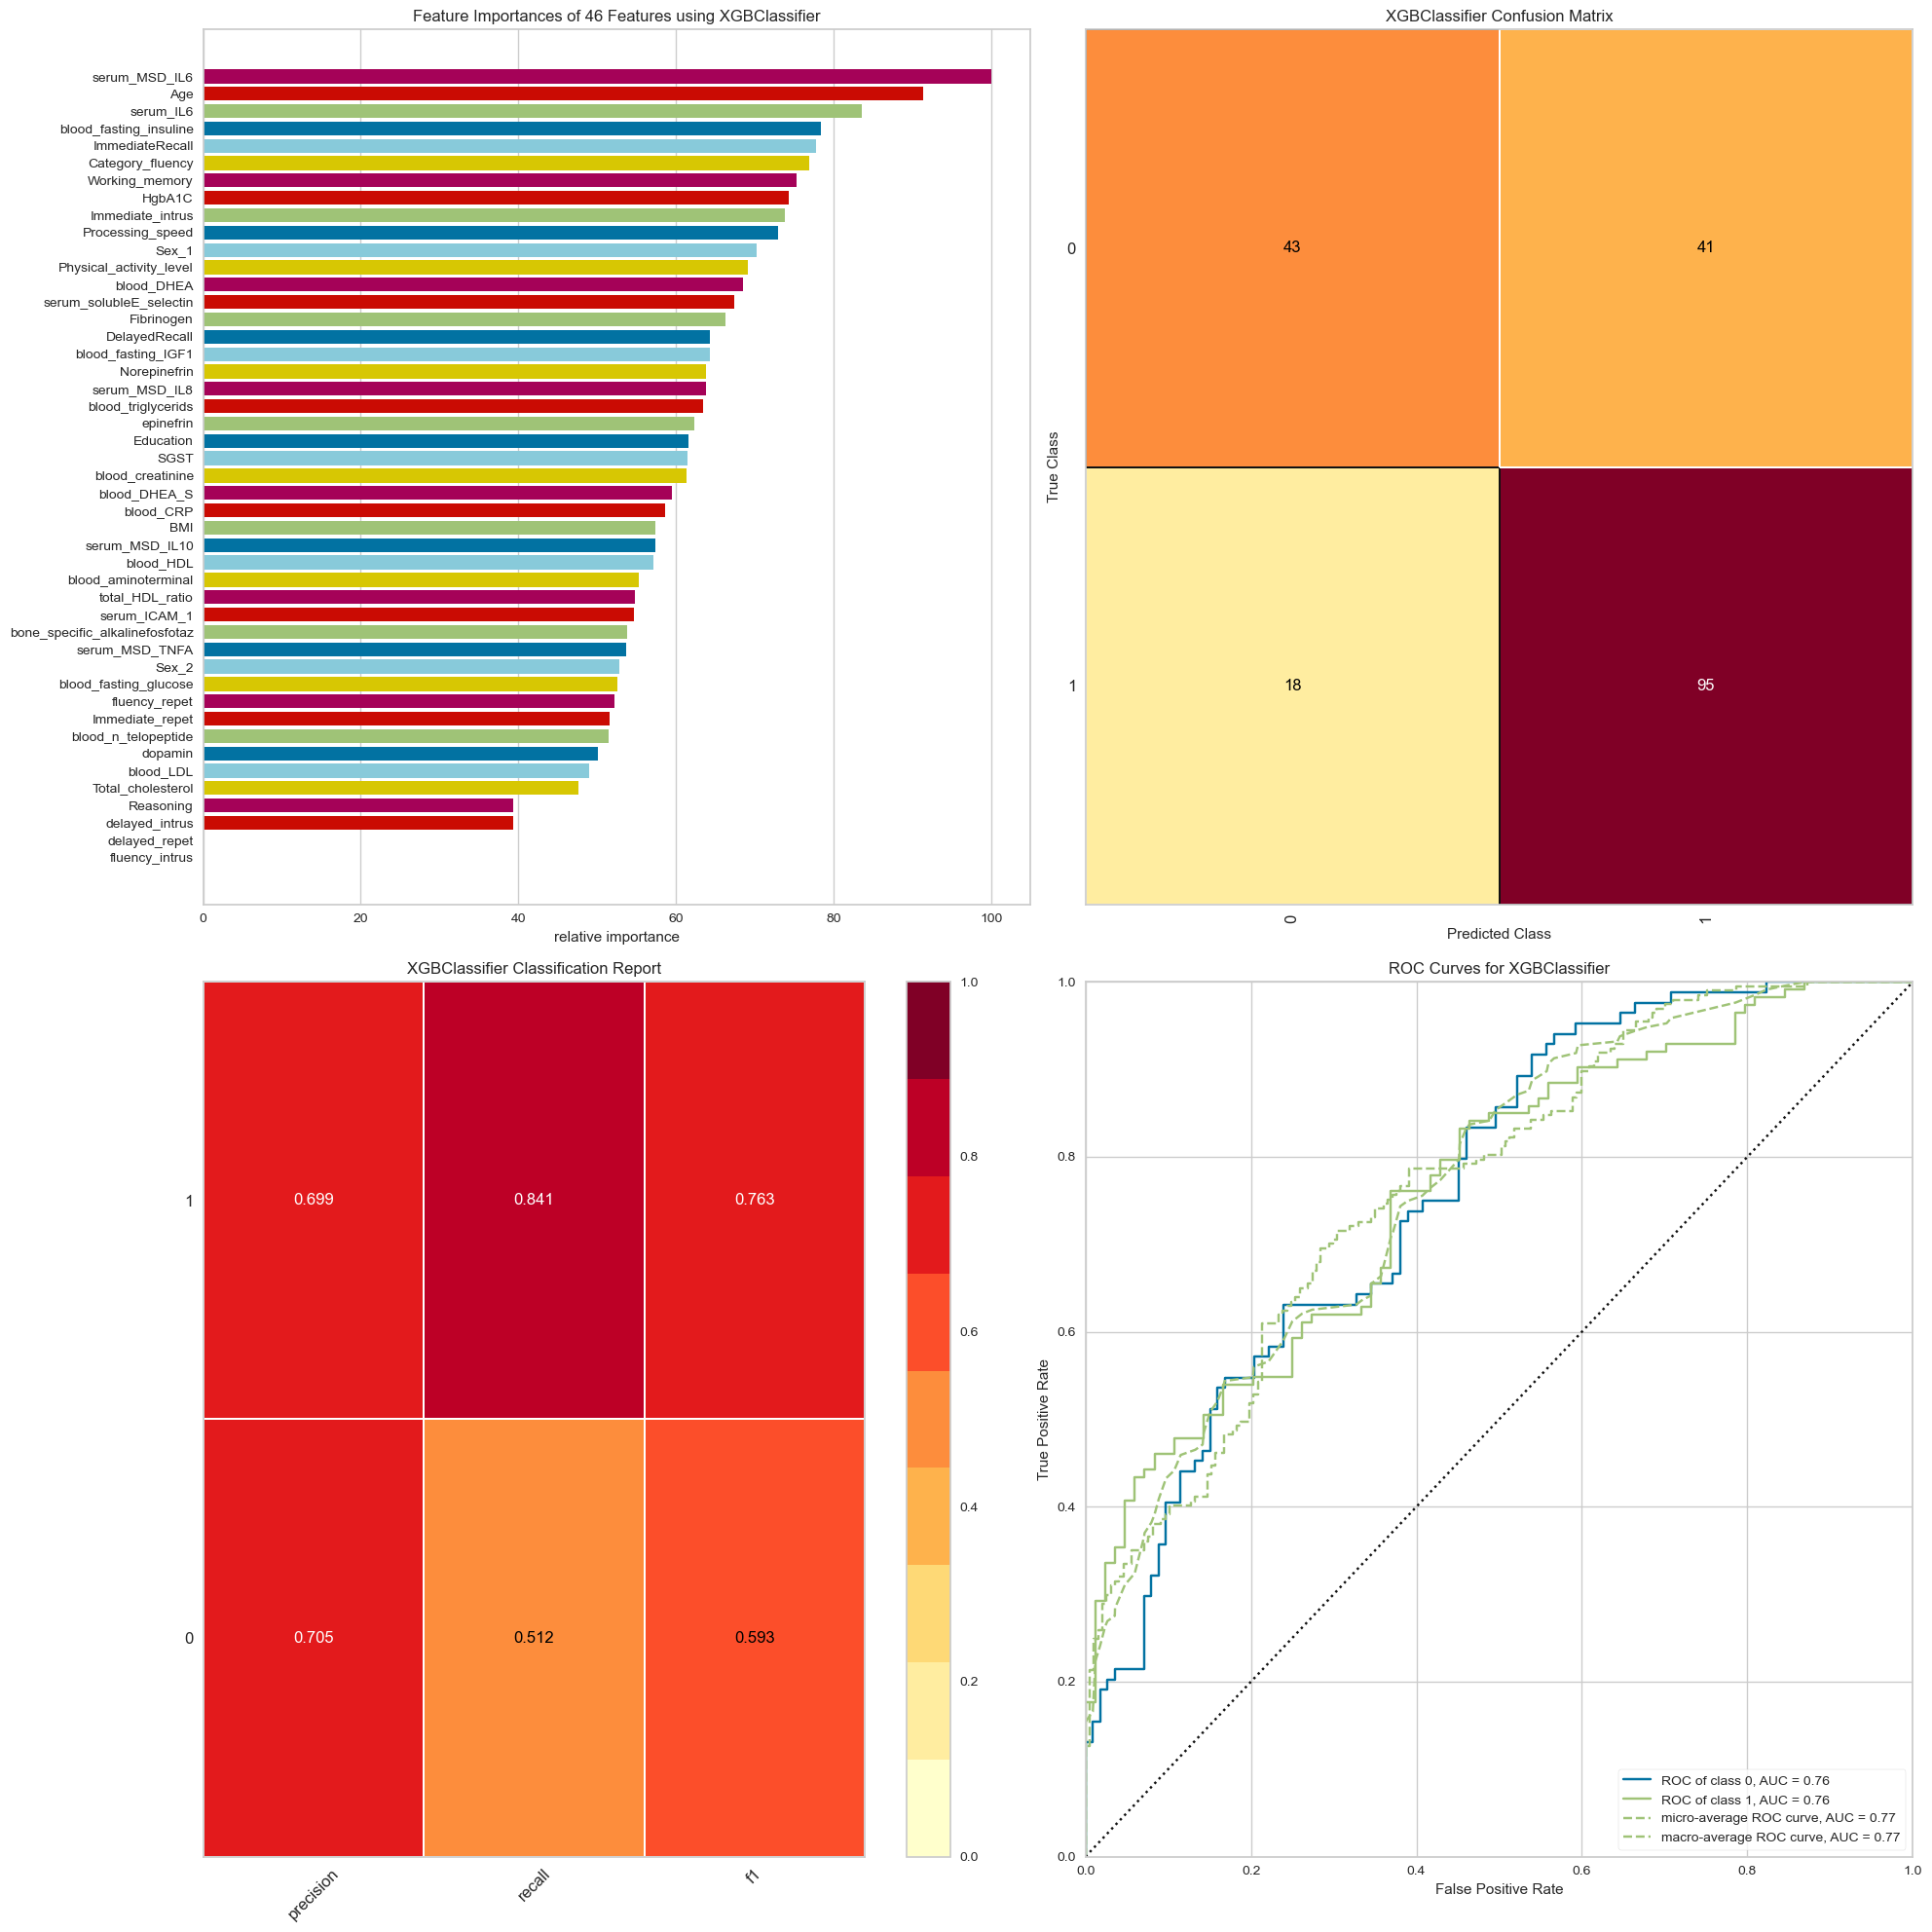

In [58]:
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

model = xgb_model
visualgrid = [
    FeatureImportances(model, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()

plt.show()


There are some variations between native XGBoost and yellowbrick feature importance plots. I will check for this difference later.

<a id = "5"></a><br>
# Try tabpfn

Tabpfn is a transformer-based neural network that specialized in small size tabular data sets. It generally performs well. Let's try it. 

In [59]:
#pip install tabpfn

In [60]:
from tabpfn import TabPFNClassifier


Tabpfn is quite a black box. I will try four different models with different N_ensemble_configurations. According to documentation, N_ensemble_configurations is the only hyperparameter.

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


C:\Users\Public\anaconda3\Lib\site-packages\botocore\utils.py:15: DeprecationWarning:

'cgi' is deprecated and slated for removal in Python 3.13

C:\Users\Public\anaconda3\Lib\site-packages\botocore\httpsession.py:41: DeprecationWarning:

'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680

C:\Users\Public\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning:

torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.

C:\Users\Public\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning:

torch.utils.checkpoint: please pass in use_reentra

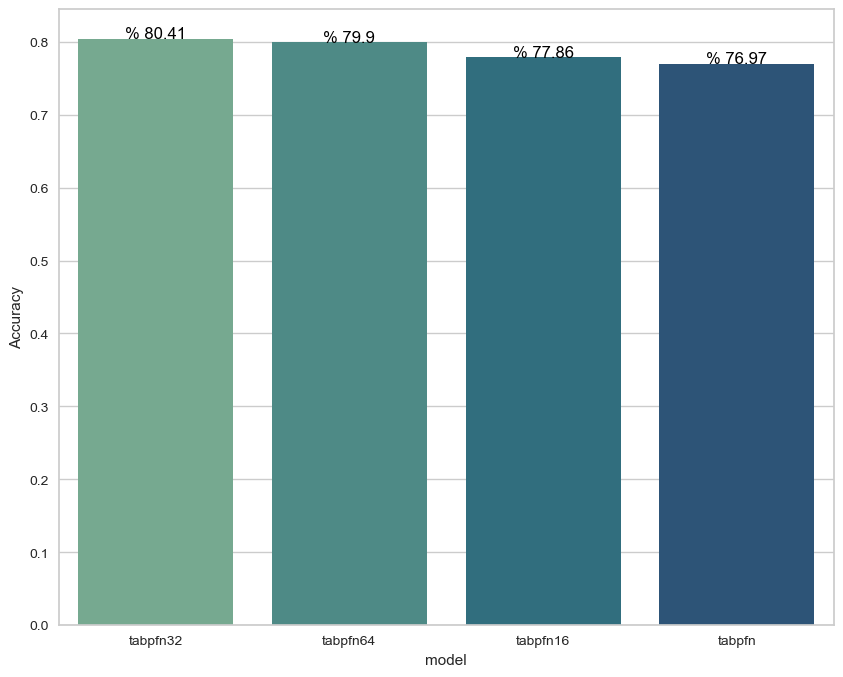

In [61]:
models = []

models.append(('tabpfn', TabPFNClassifier()))
models.append(('tabpfn16', TabPFNClassifier( N_ensemble_configurations=16)))
models.append(('tabpfn32', TabPFNClassifier( N_ensemble_configurations=32)))
models.append(('tabpfn64', TabPFNClassifier( N_ensemble_configurations=64)))



accT = []
names = []

for name, model in models:
    
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_train)
        accT.append([name, accuracy_score(y_train, y_pred)])
        
results = pd.DataFrame(accT, columns = ['model', 'Accuracy'])
groupedvalues = results.sort_values(by = 'Accuracy', ascending = False).reset_index()

plt.figure(figsize=(10,8))
g = sns.barplot(x='model', y='Accuracy', data=groupedvalues, palette = "crest")

for index, row in groupedvalues.iterrows():
    g.text(row.name, row.Accuracy, "% {}".format(round(row.Accuracy*100,2)), color='black', ha="center")
    

plt.show()

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


C:\Users\Public\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning:

torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.

C:\Users\Public\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning:

torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.

C:\Users\Public\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning:

torch.utils.checkpoint:

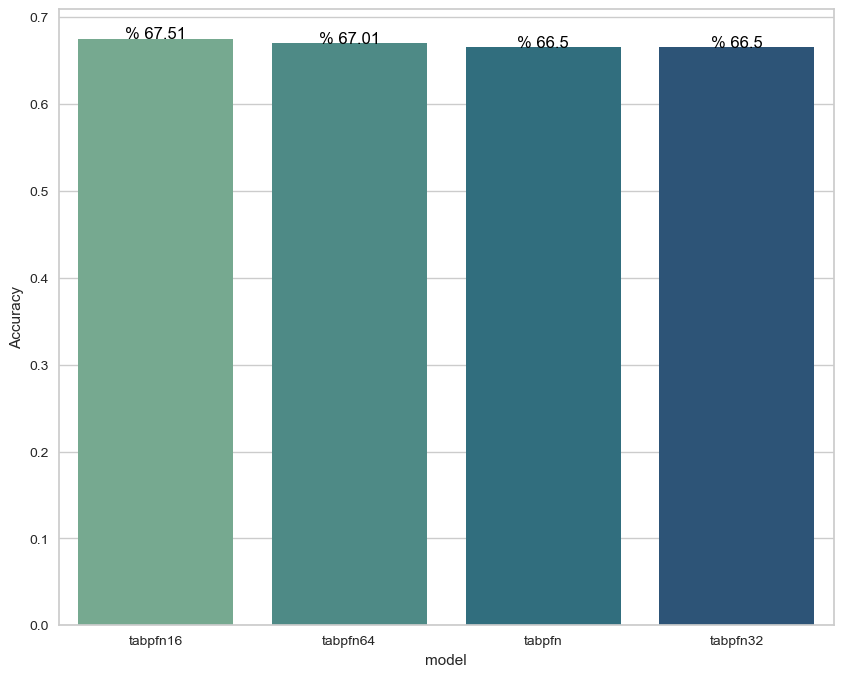

In [62]:
models = []

models.append(('tabpfn', TabPFNClassifier()))
models.append(('tabpfn16', TabPFNClassifier( N_ensemble_configurations=16)))
models.append(('tabpfn32', TabPFNClassifier( N_ensemble_configurations=32)))
models.append(('tabpfn64', TabPFNClassifier( N_ensemble_configurations=64)))



accT = []
names = []

for name, model in models:
    
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accT.append([name, accuracy_score(y_test, y_pred)])
        
results = pd.DataFrame(accT, columns = ['model', 'Accuracy'])
groupedvalues = results.sort_values(by = 'Accuracy', ascending = False).reset_index()

plt.figure(figsize=(10,8))
g = sns.barplot(x='model', y='Accuracy', data=groupedvalues, palette = "crest")

for index, row in groupedvalues.iterrows():
    g.text(row.name, row.Accuracy, "% {}".format(round(row.Accuracy*100,2)), color='black', ha="center")
    

plt.show()

Tabpfn has higher accuracy in the training set but less in the test set. A clear sign of overfitting.

Let's plot model performance summary for best performing tabpfn configuration. Unfortunately, it does not support feature importance plot. 

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


C:\Users\Public\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning:

torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.

C:\Users\Public\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning:

torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.

C:\Users\Public\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning:

torch.utils.checkpoint:

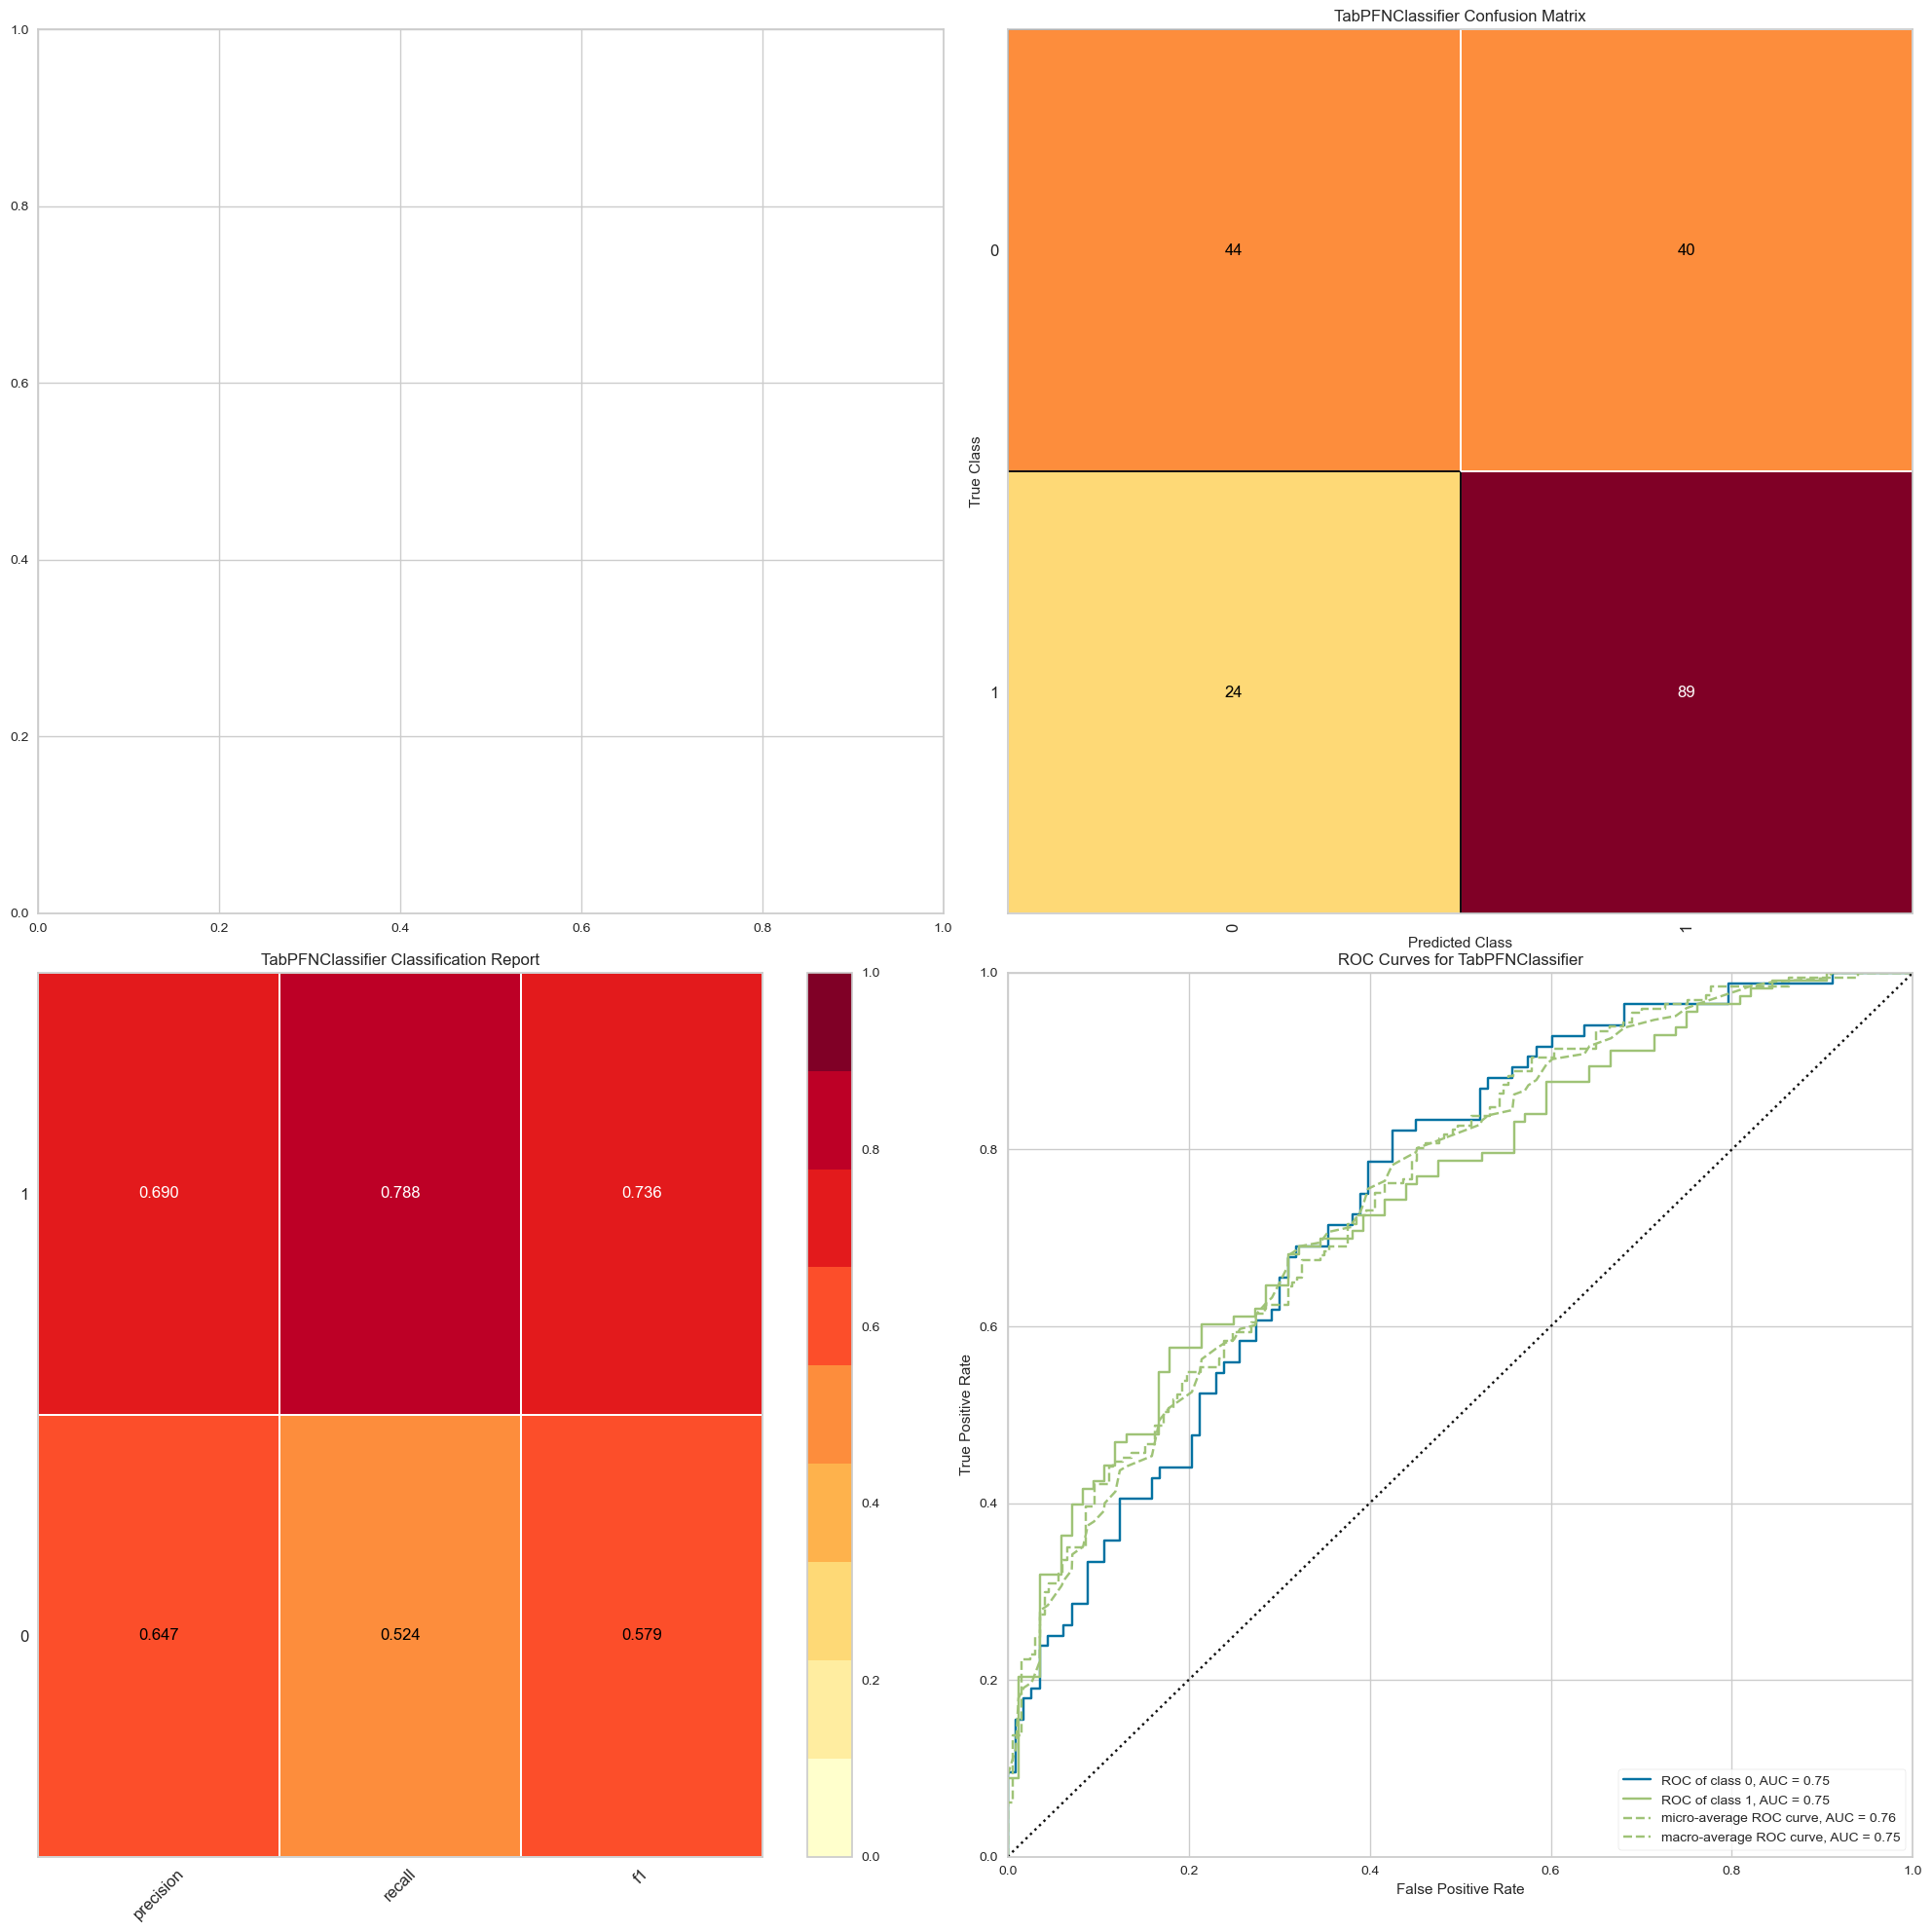

In [63]:
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

model = TabPFNClassifier( N_ensemble_configurations=16)
visualgrid = [
    #FeatureImportances(model, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()

plt.show()


<a id = "5"></a><br>
# Try flaml

Flaml is an Auto-ML library. It tries different algorithms, tunes them, and returns the performing model.

In [64]:
from flaml import AutoML

In [65]:
automl = AutoML()



In [66]:
# Specify automl goal and constraint
automl_settings = {
    
    "estimator_list" : ['lgbm', 'xgboost','xgb_limitdepth','rf','extra_tree','catboost'],
    "time_budget": 600,  # total running time in seconds
    "task": 'classification',  # task type
    "seed": random_state,  # random seed
    "metric" : 'accuracy',
    "eval_method" : 'cv',
    "n_splits" : 10,
    
}



In [67]:
automl.fit(X_train, y_train, **automl_settings)


[flaml.automl.logger: 12-21 15:57:41] {1679} INFO - task = classification
[flaml.automl.logger: 12-21 15:57:41] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 12-21 15:57:41] {1788} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 12-21 15:57:41] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'catboost']
[flaml.automl.logger: 12-21 15:57:41] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-21 15:57:41] {2344} INFO - Estimated sufficient time budget=1717s. Estimated necessary time budget=15s.
[flaml.automl.logger: 12-21 15:57:41] {2391} INFO -  at 0.2s,	estimator lgbm's best error=0.4199,	best estimator lgbm's best error=0.4199
[flaml.automl.logger: 12-21 15:57:41] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-21 15:57:42] {2391} INFO -  at 0.4s,	estimator lgbm's best error=0.4199,	best estimator lgbm's best error=0.4199
[flaml.automl.logger: 12-21 15

[flaml.automl.logger: 12-21 15:57:52] {2218} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 12-21 15:57:52] {2391} INFO -  at 10.5s,	estimator lgbm's best error=0.3473,	best estimator xgboost's best error=0.3447
[flaml.automl.logger: 12-21 15:57:52] {2218} INFO - iteration 35, current learner xgboost
[flaml.automl.logger: 12-21 15:57:52] {2391} INFO -  at 10.9s,	estimator xgboost's best error=0.3447,	best estimator xgboost's best error=0.3447
[flaml.automl.logger: 12-21 15:57:52] {2218} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 12-21 15:57:53] {2391} INFO -  at 11.3s,	estimator extra_tree's best error=0.3677,	best estimator xgboost's best error=0.3447
[flaml.automl.logger: 12-21 15:57:53] {2218} INFO - iteration 37, current learner xgboost
[flaml.automl.logger: 12-21 15:57:53] {2391} INFO -  at 11.6s,	estimator xgboost's best error=0.3447,	best estimator xgboost's best error=0.3447
[flaml.automl.logger: 12-21 15:57:53] {2218} INFO - iteratio

[flaml.automl.logger: 12-21 15:58:07] {2218} INFO - iteration 70, current learner xgboost
[flaml.automl.logger: 12-21 15:58:08] {2391} INFO -  at 26.5s,	estimator xgboost's best error=0.3447,	best estimator lgbm's best error=0.3435
[flaml.automl.logger: 12-21 15:58:08] {2218} INFO - iteration 71, current learner extra_tree
[flaml.automl.logger: 12-21 15:58:08] {2391} INFO -  at 26.9s,	estimator extra_tree's best error=0.3677,	best estimator lgbm's best error=0.3435
[flaml.automl.logger: 12-21 15:58:08] {2218} INFO - iteration 72, current learner xgboost
[flaml.automl.logger: 12-21 15:58:08] {2391} INFO -  at 27.3s,	estimator xgboost's best error=0.3447,	best estimator lgbm's best error=0.3435
[flaml.automl.logger: 12-21 15:58:08] {2218} INFO - iteration 73, current learner catboost
[flaml.automl.logger: 12-21 15:58:10] {2391} INFO -  at 28.3s,	estimator catboost's best error=0.3459,	best estimator lgbm's best error=0.3435
[flaml.automl.logger: 12-21 15:58:10] {2218} INFO - iteration 74

[flaml.automl.logger: 12-21 15:58:29] {2218} INFO - iteration 106, current learner xgboost
[flaml.automl.logger: 12-21 15:58:29] {2391} INFO -  at 47.7s,	estimator xgboost's best error=0.3447,	best estimator lgbm's best error=0.3423
[flaml.automl.logger: 12-21 15:58:29] {2218} INFO - iteration 107, current learner catboost
[flaml.automl.logger: 12-21 15:58:30] {2391} INFO -  at 49.1s,	estimator catboost's best error=0.3459,	best estimator lgbm's best error=0.3423
[flaml.automl.logger: 12-21 15:58:30] {2218} INFO - iteration 108, current learner lgbm
[flaml.automl.logger: 12-21 15:58:31] {2391} INFO -  at 49.5s,	estimator lgbm's best error=0.3423,	best estimator lgbm's best error=0.3423
[flaml.automl.logger: 12-21 15:58:31] {2218} INFO - iteration 109, current learner catboost
[flaml.automl.logger: 12-21 15:58:32] {2391} INFO -  at 50.8s,	estimator catboost's best error=0.3459,	best estimator lgbm's best error=0.3423
[flaml.automl.logger: 12-21 15:58:32] {2218} INFO - iteration 110, cur

[flaml.automl.logger: 12-21 15:58:49] {2218} INFO - iteration 142, current learner lgbm
[flaml.automl.logger: 12-21 15:58:49] {2391} INFO -  at 68.3s,	estimator lgbm's best error=0.3423,	best estimator lgbm's best error=0.3423
[flaml.automl.logger: 12-21 15:58:49] {2218} INFO - iteration 143, current learner extra_tree
[flaml.automl.logger: 12-21 15:58:50] {2391} INFO -  at 68.9s,	estimator extra_tree's best error=0.3677,	best estimator lgbm's best error=0.3423
[flaml.automl.logger: 12-21 15:58:50] {2218} INFO - iteration 144, current learner extra_tree
[flaml.automl.logger: 12-21 15:58:50] {2391} INFO -  at 69.1s,	estimator extra_tree's best error=0.3639,	best estimator lgbm's best error=0.3423
[flaml.automl.logger: 12-21 15:58:50] {2218} INFO - iteration 145, current learner xgboost
[flaml.automl.logger: 12-21 15:58:51] {2391} INFO -  at 69.5s,	estimator xgboost's best error=0.3447,	best estimator lgbm's best error=0.3423
[flaml.automl.logger: 12-21 15:58:51] {2218} INFO - iteration 

[flaml.automl.logger: 12-21 15:59:04] {2218} INFO - iteration 178, current learner lgbm
[flaml.automl.logger: 12-21 15:59:04] {2391} INFO -  at 83.3s,	estimator lgbm's best error=0.3396,	best estimator lgbm's best error=0.3396
[flaml.automl.logger: 12-21 15:59:04] {2218} INFO - iteration 179, current learner xgboost
[flaml.automl.logger: 12-21 15:59:05] {2391} INFO -  at 83.5s,	estimator xgboost's best error=0.3447,	best estimator lgbm's best error=0.3396
[flaml.automl.logger: 12-21 15:59:05] {2218} INFO - iteration 180, current learner rf
[flaml.automl.logger: 12-21 15:59:05] {2391} INFO -  at 83.9s,	estimator rf's best error=0.3600,	best estimator lgbm's best error=0.3396
[flaml.automl.logger: 12-21 15:59:05] {2218} INFO - iteration 181, current learner xgboost
[flaml.automl.logger: 12-21 15:59:05] {2391} INFO -  at 84.2s,	estimator xgboost's best error=0.3447,	best estimator lgbm's best error=0.3396
[flaml.automl.logger: 12-21 15:59:05] {2218} INFO - iteration 182, current learner l

[flaml.automl.logger: 12-21 15:59:24] {2218} INFO - iteration 214, current learner catboost
[flaml.automl.logger: 12-21 15:59:25] {2391} INFO -  at 103.8s,	estimator catboost's best error=0.3459,	best estimator lgbm's best error=0.3396
[flaml.automl.logger: 12-21 15:59:25] {2218} INFO - iteration 215, current learner lgbm
[flaml.automl.logger: 12-21 15:59:25] {2391} INFO -  at 104.1s,	estimator lgbm's best error=0.3396,	best estimator lgbm's best error=0.3396
[flaml.automl.logger: 12-21 15:59:25] {2218} INFO - iteration 216, current learner catboost
[flaml.automl.logger: 12-21 15:59:26] {2391} INFO -  at 105.0s,	estimator catboost's best error=0.3459,	best estimator lgbm's best error=0.3396
[flaml.automl.logger: 12-21 15:59:26] {2218} INFO - iteration 217, current learner lgbm
[flaml.automl.logger: 12-21 15:59:26] {2391} INFO -  at 105.3s,	estimator lgbm's best error=0.3396,	best estimator lgbm's best error=0.3396
[flaml.automl.logger: 12-21 15:59:26] {2218} INFO - iteration 218, curre

[flaml.automl.logger: 12-21 15:59:55] {2391} INFO -  at 133.4s,	estimator xgb_limitdepth's best error=0.3664,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 15:59:55] {2218} INFO - iteration 249, current learner xgboost
[flaml.automl.logger: 12-21 15:59:55] {2391} INFO -  at 133.8s,	estimator xgboost's best error=0.3447,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 15:59:55] {2218} INFO - iteration 250, current learner extra_tree
[flaml.automl.logger: 12-21 15:59:55] {2391} INFO -  at 134.2s,	estimator extra_tree's best error=0.3359,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 15:59:55] {2218} INFO - iteration 251, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 15:59:56] {2391} INFO -  at 134.7s,	estimator xgb_limitdepth's best error=0.3664,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 15:59:56] {2218} INFO - iteration 252, current learner lgbm
[flaml.automl.lo

[flaml.automl.logger: 12-21 16:00:23] {2391} INFO -  at 161.8s,	estimator xgboost's best error=0.3447,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:00:23] {2218} INFO - iteration 283, current learner xgboost
[flaml.automl.logger: 12-21 16:00:23] {2391} INFO -  at 162.1s,	estimator xgboost's best error=0.3447,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:00:23] {2218} INFO - iteration 284, current learner xgboost
[flaml.automl.logger: 12-21 16:00:24] {2391} INFO -  at 162.4s,	estimator xgboost's best error=0.3447,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:00:24] {2218} INFO - iteration 285, current learner extra_tree
[flaml.automl.logger: 12-21 16:00:35] {2391} INFO -  at 174.0s,	estimator extra_tree's best error=0.3359,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:00:35] {2218} INFO - iteration 286, current learner catboost
[flaml.automl.logger: 12-21 16:00

[flaml.automl.logger: 12-21 16:00:50] {2218} INFO - iteration 316, current learner catboost
[flaml.automl.logger: 12-21 16:00:53] {2391} INFO -  at 191.5s,	estimator catboost's best error=0.3459,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:00:53] {2218} INFO - iteration 317, current learner catboost
[flaml.automl.logger: 12-21 16:00:55] {2391} INFO -  at 193.3s,	estimator catboost's best error=0.3459,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:00:55] {2218} INFO - iteration 318, current learner xgboost
[flaml.automl.logger: 12-21 16:00:55] {2391} INFO -  at 193.7s,	estimator xgboost's best error=0.3447,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:00:55] {2218} INFO - iteration 319, current learner lgbm
[flaml.automl.logger: 12-21 16:00:55] {2391} INFO -  at 193.8s,	estimator lgbm's best error=0.3384,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:00:55] {221

[flaml.automl.logger: 12-21 16:01:10] {2218} INFO - iteration 350, current learner lgbm
[flaml.automl.logger: 12-21 16:01:10] {2391} INFO -  at 209.1s,	estimator lgbm's best error=0.3384,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:01:10] {2218} INFO - iteration 351, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:01:10] {2391} INFO -  at 209.3s,	estimator xgb_limitdepth's best error=0.3537,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:01:10] {2218} INFO - iteration 352, current learner rf
[flaml.automl.logger: 12-21 16:01:11] {2391} INFO -  at 209.9s,	estimator rf's best error=0.3600,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:01:11] {2218} INFO - iteration 353, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:01:12] {2391} INFO -  at 210.4s,	estimator xgb_limitdepth's best error=0.3537,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 

[flaml.automl.logger: 12-21 16:01:33] {2218} INFO - iteration 384, current learner rf
[flaml.automl.logger: 12-21 16:01:34] {2391} INFO -  at 233.1s,	estimator rf's best error=0.3600,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:01:34] {2218} INFO - iteration 385, current learner xgboost
[flaml.automl.logger: 12-21 16:01:35] {2391} INFO -  at 233.3s,	estimator xgboost's best error=0.3447,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:01:35] {2218} INFO - iteration 386, current learner xgboost
[flaml.automl.logger: 12-21 16:01:35] {2391} INFO -  at 233.7s,	estimator xgboost's best error=0.3447,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:01:35] {2218} INFO - iteration 387, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:01:35] {2391} INFO -  at 233.8s,	estimator xgb_limitdepth's best error=0.3537,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:01:35

[flaml.automl.logger: 12-21 16:01:56] {2218} INFO - iteration 418, current learner extra_tree
[flaml.automl.logger: 12-21 16:01:56] {2391} INFO -  at 254.7s,	estimator extra_tree's best error=0.3359,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:01:56] {2218} INFO - iteration 419, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:01:56] {2391} INFO -  at 254.9s,	estimator xgb_limitdepth's best error=0.3537,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:01:56] {2218} INFO - iteration 420, current learner extra_tree
[flaml.automl.logger: 12-21 16:01:57] {2391} INFO -  at 255.6s,	estimator extra_tree's best error=0.3359,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:01:57] {2218} INFO - iteration 421, current learner xgboost
[flaml.automl.logger: 12-21 16:01:57] {2391} INFO -  at 256.0s,	estimator xgboost's best error=0.3447,	best estimator extra_tree's best error=0.3359
[flaml.automl.

[flaml.automl.logger: 12-21 16:02:15] {2391} INFO -  at 273.9s,	estimator extra_tree's best error=0.3359,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:02:15] {2218} INFO - iteration 453, current learner catboost
[flaml.automl.logger: 12-21 16:02:19] {2391} INFO -  at 278.2s,	estimator catboost's best error=0.3459,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:02:19] {2218} INFO - iteration 454, current learner lgbm
[flaml.automl.logger: 12-21 16:02:20] {2391} INFO -  at 278.4s,	estimator lgbm's best error=0.3371,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:02:20] {2218} INFO - iteration 455, current learner lgbm
[flaml.automl.logger: 12-21 16:02:20] {2391} INFO -  at 278.6s,	estimator lgbm's best error=0.3371,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:02:20] {2218} INFO - iteration 456, current learner lgbm
[flaml.automl.logger: 12-21 16:02:20] {2391} INFO 

[flaml.automl.logger: 12-21 16:02:46] {2218} INFO - iteration 487, current learner extra_tree
[flaml.automl.logger: 12-21 16:02:47] {2391} INFO -  at 306.2s,	estimator extra_tree's best error=0.3359,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:02:47] {2218} INFO - iteration 488, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:02:48] {2391} INFO -  at 306.5s,	estimator xgb_limitdepth's best error=0.3537,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:02:48] {2218} INFO - iteration 489, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:02:48] {2391} INFO -  at 306.8s,	estimator xgb_limitdepth's best error=0.3537,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:02:48] {2218} INFO - iteration 490, current learner lgbm
[flaml.automl.logger: 12-21 16:02:48] {2391} INFO -  at 307.0s,	estimator lgbm's best error=0.3371,	best estimator extra_tree's best error=0.3359
[flaml.autom

[flaml.automl.logger: 12-21 16:03:14] {2391} INFO -  at 332.9s,	estimator xgb_limitdepth's best error=0.3498,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:03:14] {2218} INFO - iteration 522, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:03:14] {2391} INFO -  at 333.3s,	estimator xgb_limitdepth's best error=0.3498,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:03:14] {2218} INFO - iteration 523, current learner lgbm
[flaml.automl.logger: 12-21 16:03:15] {2391} INFO -  at 333.5s,	estimator lgbm's best error=0.3371,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:03:15] {2218} INFO - iteration 524, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:03:15] {2391} INFO -  at 333.8s,	estimator xgb_limitdepth's best error=0.3498,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:03:15] {2218} INFO - iteration 525, current learner catboost
[flaml.aut

[flaml.automl.logger: 12-21 16:03:50] {2391} INFO -  at 368.5s,	estimator lgbm's best error=0.3371,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:03:50] {2218} INFO - iteration 556, current learner lgbm
[flaml.automl.logger: 12-21 16:03:50] {2391} INFO -  at 368.7s,	estimator lgbm's best error=0.3371,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:03:50] {2218} INFO - iteration 557, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:03:50] {2391} INFO -  at 369.1s,	estimator xgb_limitdepth's best error=0.3498,	best estimator extra_tree's best error=0.3359
[flaml.automl.logger: 12-21 16:03:50] {2218} INFO - iteration 558, current learner extra_tree
[flaml.automl.logger: 12-21 16:03:51] {2391} INFO -  at 369.7s,	estimator extra_tree's best error=0.3333,	best estimator extra_tree's best error=0.3333
[flaml.automl.logger: 12-21 16:03:51] {2218} INFO - iteration 559, current learner xgb_limitdepth
[flaml.automl.logger: 

[flaml.automl.logger: 12-21 16:04:21] {2218} INFO - iteration 589, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:04:21] {2391} INFO -  at 400.2s,	estimator xgb_limitdepth's best error=0.3498,	best estimator extra_tree's best error=0.3333
[flaml.automl.logger: 12-21 16:04:21] {2218} INFO - iteration 590, current learner extra_tree
[flaml.automl.logger: 12-21 16:04:22] {2391} INFO -  at 400.6s,	estimator extra_tree's best error=0.3333,	best estimator extra_tree's best error=0.3333
[flaml.automl.logger: 12-21 16:04:22] {2218} INFO - iteration 591, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:04:22] {2391} INFO -  at 401.0s,	estimator xgb_limitdepth's best error=0.3498,	best estimator extra_tree's best error=0.3333
[flaml.automl.logger: 12-21 16:04:22] {2218} INFO - iteration 592, current learner extra_tree
[flaml.automl.logger: 12-21 16:04:23] {2391} INFO -  at 401.7s,	estimator extra_tree's best error=0.3333,	best estimator extra_tree's best error=0.3333


[flaml.automl.logger: 12-21 16:04:51] {2391} INFO -  at 430.2s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:04:51] {2218} INFO - iteration 623, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:04:52] {2391} INFO -  at 430.5s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:04:52] {2218} INFO - iteration 624, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:04:52] {2391} INFO -  at 430.7s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:04:52] {2218} INFO - iteration 625, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:04:52] {2391} INFO -  at 431.3s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:04:52] {2218} INFO - iteration 626,

[flaml.automl.logger: 12-21 16:05:03] {2391} INFO -  at 441.8s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:05:03] {2218} INFO - iteration 655, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:05:03] {2391} INFO -  at 442.2s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:05:03] {2218} INFO - iteration 656, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:05:04] {2391} INFO -  at 442.5s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:05:04] {2218} INFO - iteration 657, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:05:04] {2391} INFO -  at 442.8s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:05:04] {2218} INFO - iteration 658,

[flaml.automl.logger: 12-21 16:05:22] {2218} INFO - iteration 687, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:05:23] {2391} INFO -  at 461.6s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:05:23] {2218} INFO - iteration 688, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:05:23] {2391} INFO -  at 461.9s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:05:23] {2218} INFO - iteration 689, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:05:23] {2391} INFO -  at 462.2s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:05:23] {2218} INFO - iteration 690, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:05:24] {2391} INFO -  at 462.5s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb

[flaml.automl.logger: 12-21 16:05:33] {2218} INFO - iteration 719, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:05:33] {2391} INFO -  at 471.8s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:05:33] {2218} INFO - iteration 720, current learner extra_tree
[flaml.automl.logger: 12-21 16:05:33] {2391} INFO -  at 472.3s,	estimator extra_tree's best error=0.3333,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:05:33] {2218} INFO - iteration 721, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:05:34] {2391} INFO -  at 472.6s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:05:34] {2218} INFO - iteration 722, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:05:34] {2391} INFO -  at 472.9s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitde

[flaml.automl.logger: 12-21 16:06:01] {2391} INFO -  at 500.0s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:06:01] {2218} INFO - iteration 752, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:06:02] {2391} INFO -  at 500.5s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:06:02] {2218} INFO - iteration 753, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:06:02] {2391} INFO -  at 500.8s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:06:02] {2218} INFO - iteration 754, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:06:02] {2391} INFO -  at 501.1s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:06:02] {2218} INFO - iteration 755,

[flaml.automl.logger: 12-21 16:06:19] {2218} INFO - iteration 784, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:06:19] {2391} INFO -  at 517.5s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:06:19] {2218} INFO - iteration 785, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:06:19] {2391} INFO -  at 517.9s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:06:19] {2218} INFO - iteration 786, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:06:19] {2391} INFO -  at 518.2s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:06:19] {2218} INFO - iteration 787, current learner catboost
[flaml.automl.logger: 12-21 16:06:23] {2391} INFO -  at 522.1s,	estimator catboost's best error=0.3346,	best estimator xgb_limitdepth'

[flaml.automl.logger: 12-21 16:06:38] {2391} INFO -  at 536.8s,	estimator lgbm's best error=0.3371,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:06:38] {2218} INFO - iteration 817, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:06:38] {2391} INFO -  at 537.0s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:06:38] {2218} INFO - iteration 818, current learner catboost
[flaml.automl.logger: 12-21 16:06:42] {2391} INFO -  at 540.4s,	estimator catboost's best error=0.3346,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:06:42] {2218} INFO - iteration 819, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:06:42] {2391} INFO -  at 540.8s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:06:42] {2218} INFO - iteration 820, current learner xgb_l

[flaml.automl.logger: 12-21 16:06:53] {2218} INFO - iteration 849, current learner extra_tree
[flaml.automl.logger: 12-21 16:06:53] {2391} INFO -  at 552.2s,	estimator extra_tree's best error=0.3333,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:06:53] {2218} INFO - iteration 850, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:06:54] {2391} INFO -  at 552.4s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:06:54] {2218} INFO - iteration 851, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:06:54] {2391} INFO -  at 552.8s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:06:54] {2218} INFO - iteration 852, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:06:54] {2391} INFO -  at 553.1s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitde

[flaml.automl.logger: 12-21 16:07:15] {2218} INFO - iteration 882, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:07:15] {2391} INFO -  at 573.5s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:07:15] {2218} INFO - iteration 883, current learner lgbm
[flaml.automl.logger: 12-21 16:07:15] {2391} INFO -  at 573.8s,	estimator lgbm's best error=0.3371,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:07:15] {2218} INFO - iteration 884, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:07:16] {2391} INFO -  at 574.4s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:07:16] {2218} INFO - iteration 885, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:07:16] {2391} INFO -  at 574.6s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best e

[flaml.automl.logger: 12-21 16:07:40] {2391} INFO -  at 599.0s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:07:40] {2218} INFO - iteration 915, current learner lgbm
[flaml.automl.logger: 12-21 16:07:40] {2391} INFO -  at 599.1s,	estimator lgbm's best error=0.3371,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:07:40] {2218} INFO - iteration 916, current learner xgb_limitdepth
[flaml.automl.logger: 12-21 16:07:41] {2391} INFO -  at 599.4s,	estimator xgb_limitdepth's best error=0.3282,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:07:41] {2218} INFO - iteration 917, current learner xgboost
[flaml.automl.logger: 12-21 16:07:41] {2391} INFO -  at 599.7s,	estimator xgboost's best error=0.3422,	best estimator xgb_limitdepth's best error=0.3282
[flaml.automl.logger: 12-21 16:07:41] {2218} INFO - iteration 918, current learner lgbm
[flaml.autom

In [68]:
y_pred = automl.predict(X_test)
accuracy_score(y_test, y_pred)

0.6751269035532995

Let's plot model performance summary for best performing model

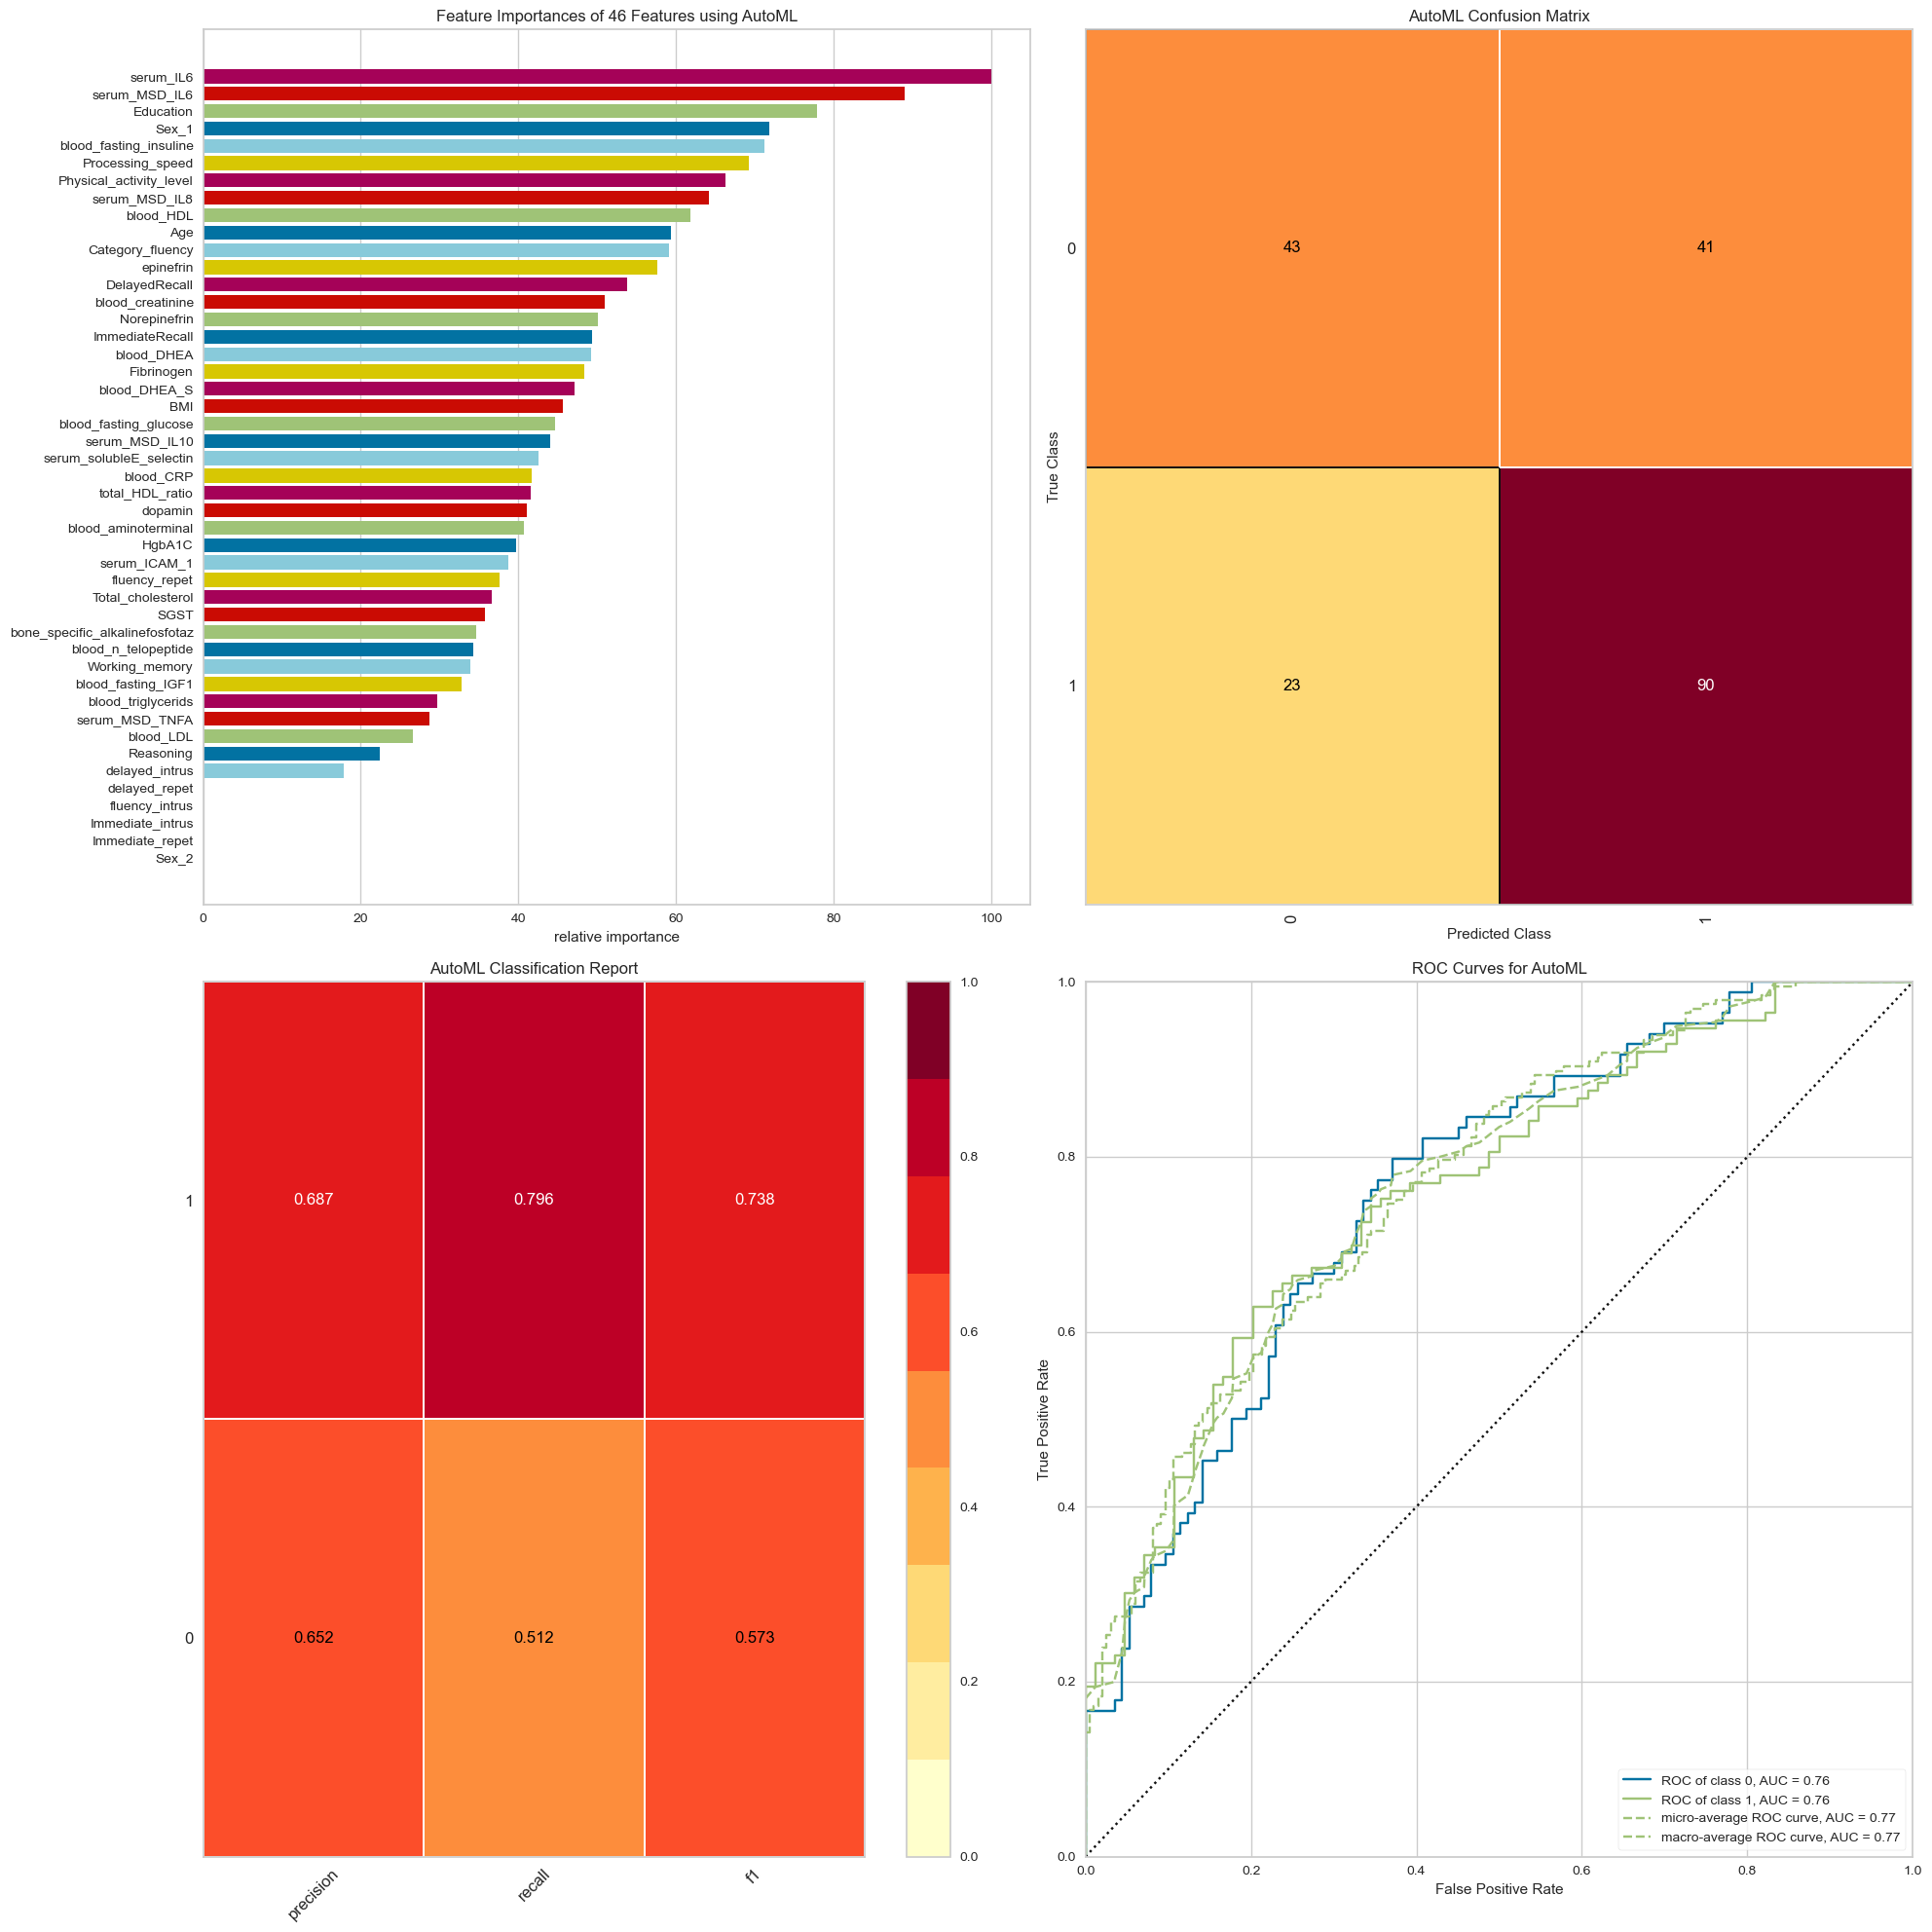

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

model = automl
visualgrid = [
    FeatureImportances(model, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()

plt.show()

<a id = "5"></a><br>
# Model Comparison

AUC comparison of models.

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


C:\Users\Public\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning:

torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.

C:\Users\Public\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning:

torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.



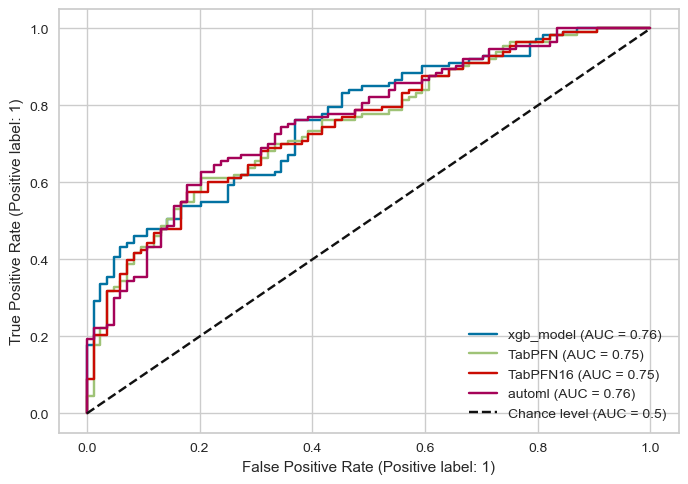

In [70]:
m1 = xgb_model
m2 = TabPFNClassifier()
m3 = TabPFNClassifier(N_ensemble_configurations=16)
m4 = automl

#m1.fit(X_train, y_train);
m2.fit(X_train, y_train);
m3.fit(X_train, y_train);
#m4.fit(X_train, y_train);


disp = RocCurveDisplay.from_estimator(m1, X_test, y_test, name= 'xgb_model')
RocCurveDisplay.from_estimator(m2, X_test, y_test, name= 'TabPFN', ax=disp.ax_);
RocCurveDisplay.from_estimator(m3, X_test, y_test, name= 'TabPFN16', ax=disp.ax_);
RocCurveDisplay.from_estimator(m4, X_test, y_test, plot_chance_level=True, name= 'automl', ax=disp.ax_);


All tried models have smillar performances and they are better than the dummy classifier. 

<a id = "5"></a><br>
# future Work

* Feature engineering
* Ensemble modelling
* Try different discretization threshold on target